In [148]:
from IPython.display import Image

import os
import datetime
import pprint
import json

import seaborn as sns

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,accuracy_score,precision_score,recall_score
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

tf.keras.backend.clear_session()

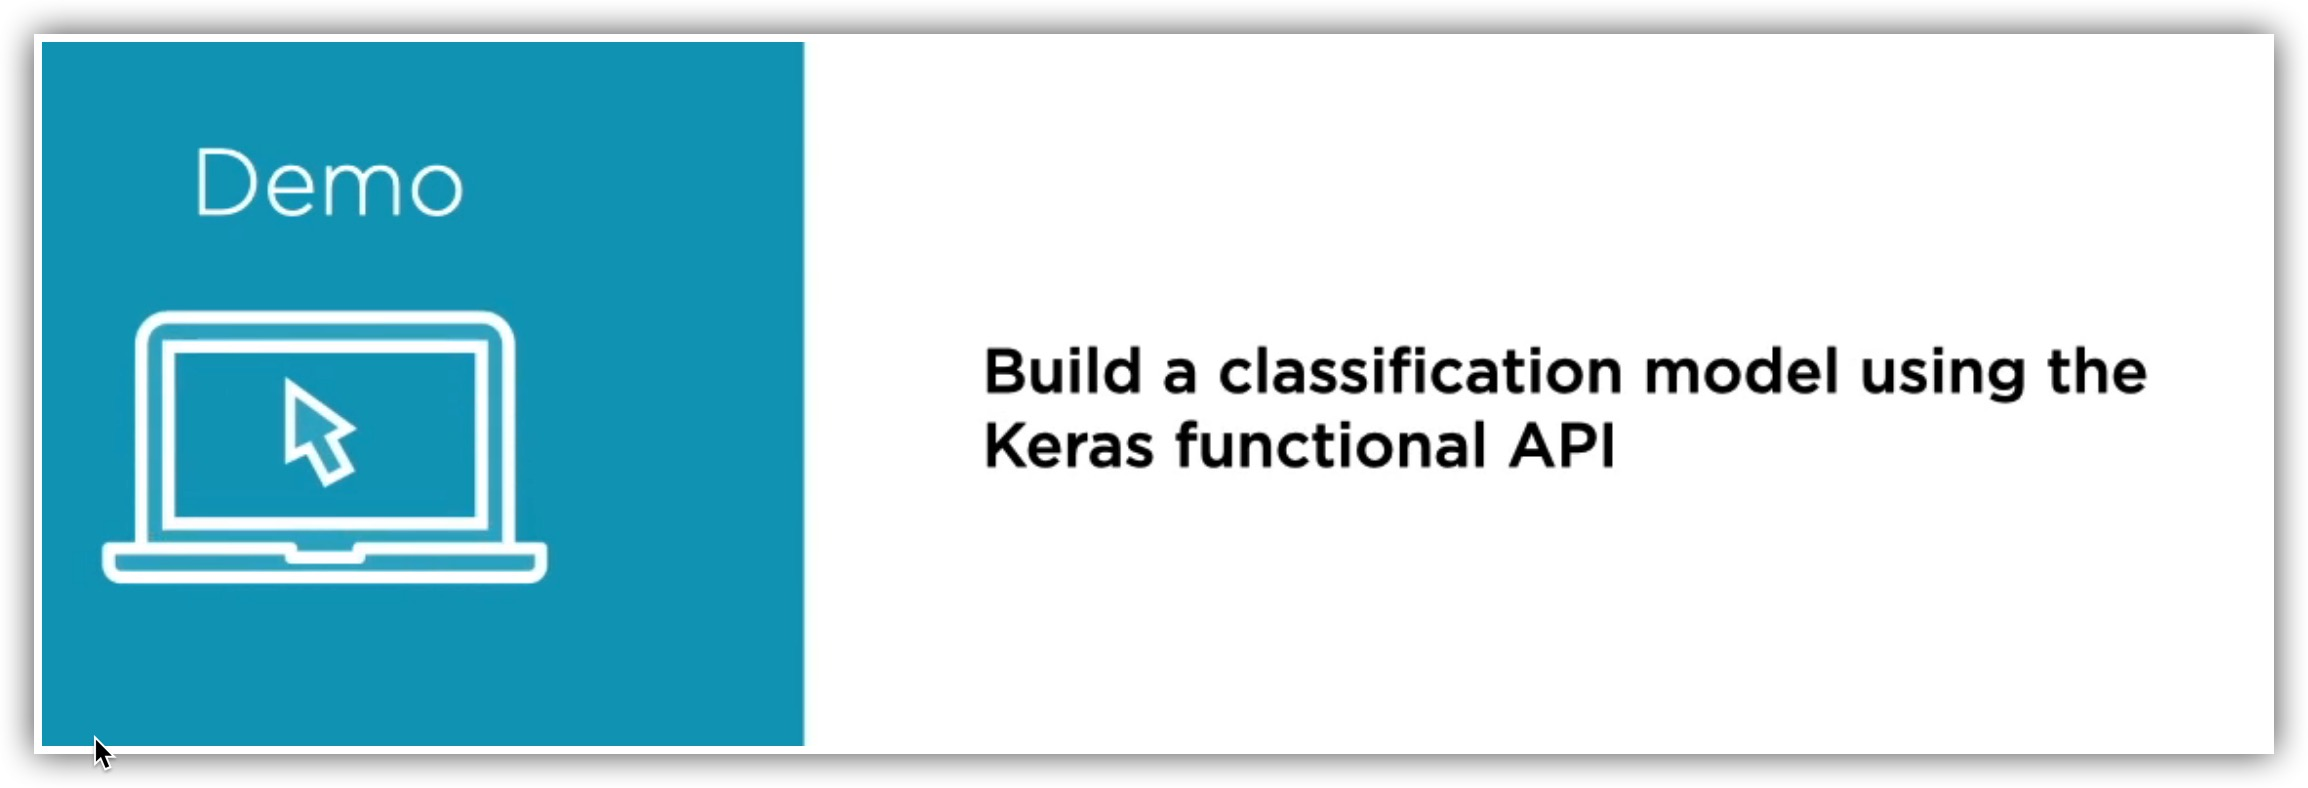

In [69]:
Image('/Users/subhasish/Development/GIT/Interstellar/SB-AI-DEV/DL/CNN/Pluralsight/Janani Ravi/Build a Machine Learning Workflow with Keras TensorFlow 2.0/SB/Images/2023-05-27_22-29-38.jpg')

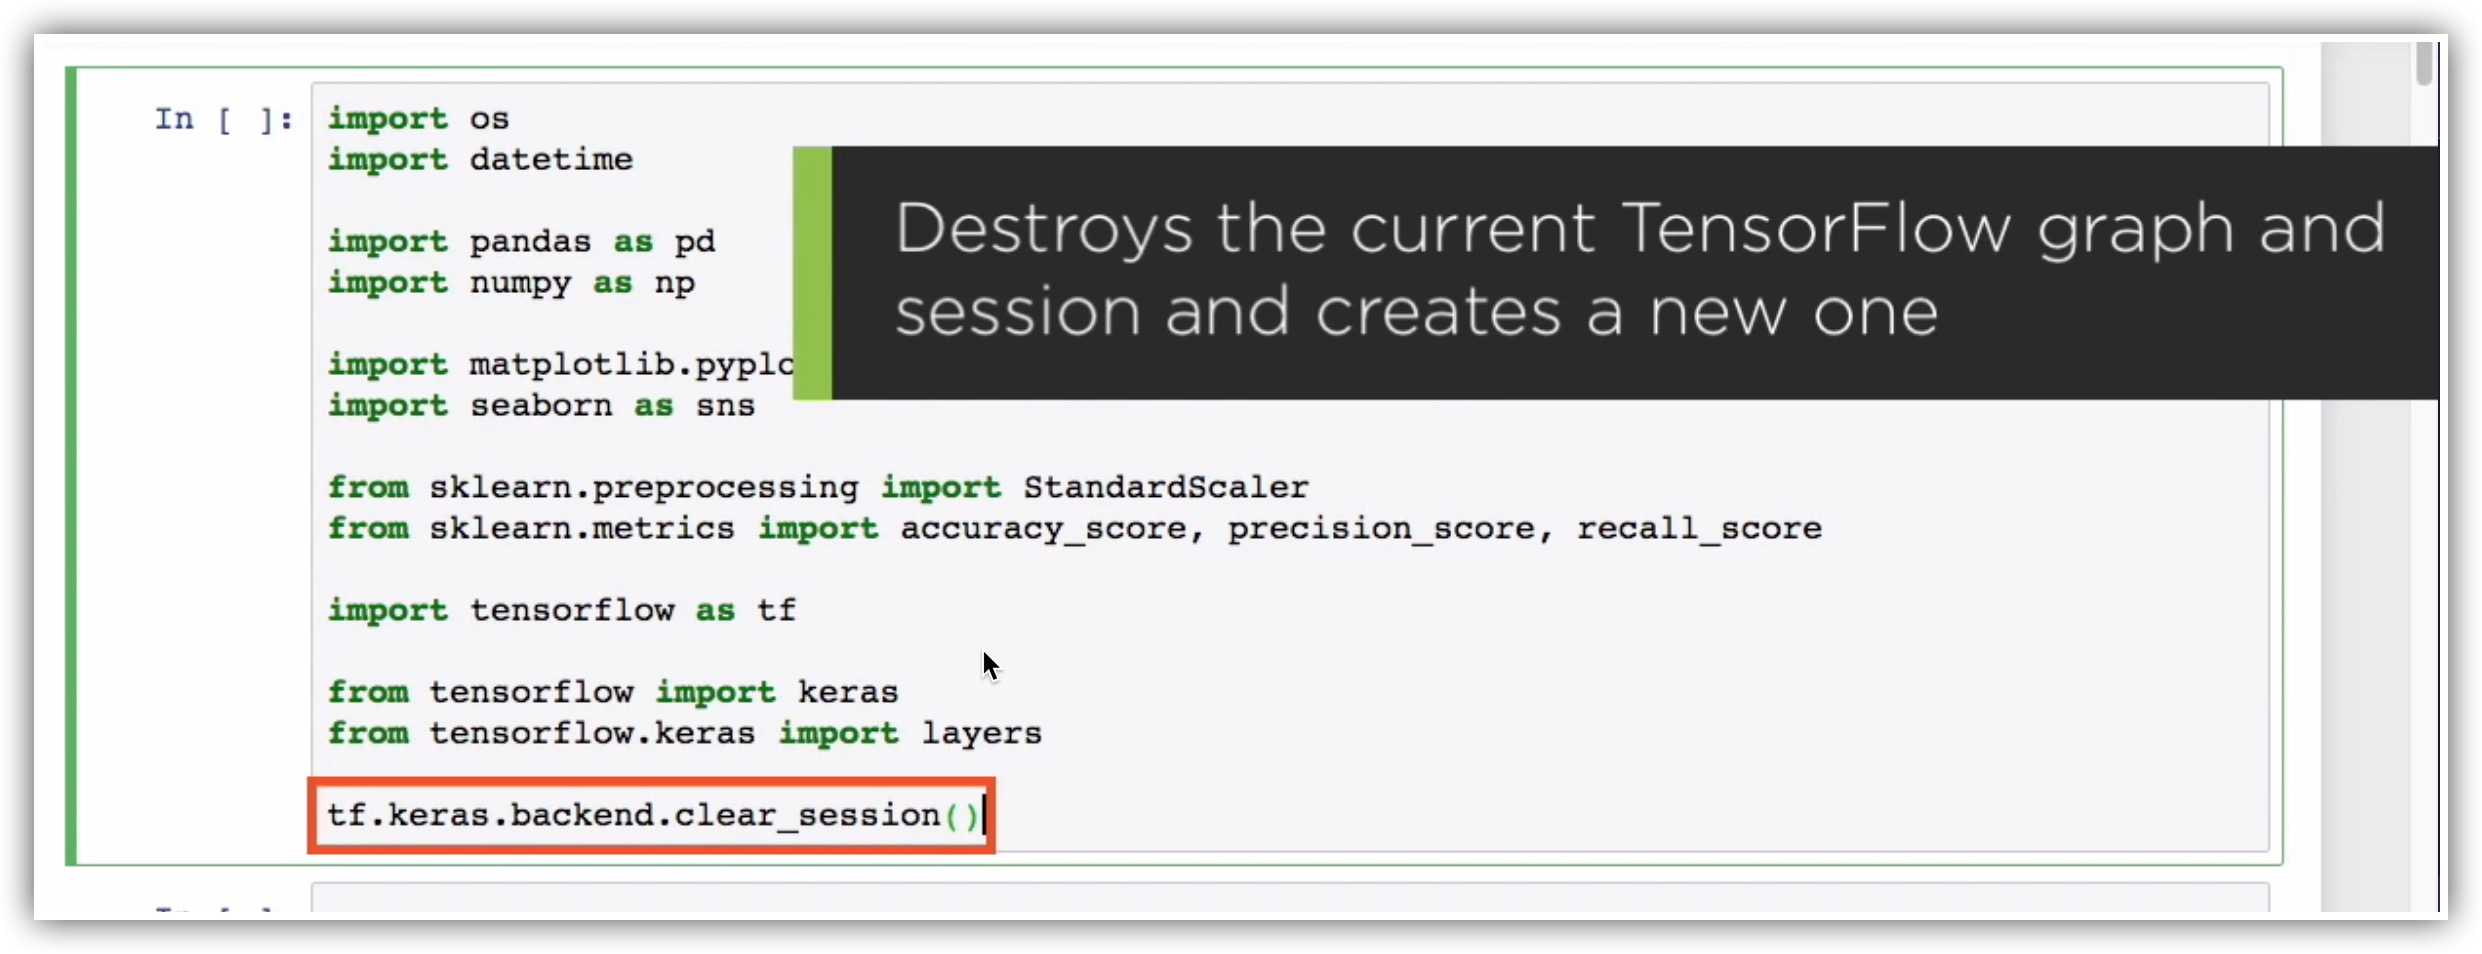

In [70]:
'''
In case you're building multiple models using the same Python kernel, you might want to use clear_session 
to ensure that you've gotten rid of your current session and you're starting off fresh. 
'''
Image('/Users/subhasish/Development/GIT/Interstellar/SB-AI-DEV/DL/CNN/Pluralsight/Janani Ravi/Build a Machine Learning Workflow with Keras TensorFlow 2.0/SB/Images/2023-05-27_22-33-19.jpg')

In [71]:
#https://www.kaggle.com/datasets/sammy123/lower-back-pain-symptoms-dataset


'''
Let's move on and let's go ahead and read in the CSV file that contains our data.
can see that the data that it contains includes attributes of the spine as measured in a medical examination. 

In our classification model here, we'll use these spine attributes to determine whether the spine displays any abnormality. 

'''
spine_data = pd.read_csv('datasets/Dataset_spine.csv', 
                         skiprows=1,
                         names=['pelvic_incidence',
                                'pelvic tilt',
                                'lumbar_lordosis_angle',
                                'sacral_slope',
                                'pelvic_radius',
                                'degree_spondylolisthesis',
                                'pelvic_slope',
                                'direct_tilt',
                                'thoracic_slope',
                                'cervical_tilt',
                                'sacrum_angle',
                                'scoliosis_slope',
                                'class_att'])

spine_data = spine_data.sample(frac=1).reset_index(drop=True)

In [72]:
from tabulate import tabulate
def DisplayMatrix(M):
    print(tabulate(M, headers='keys', tablefmt='double_grid'))

In [73]:
'''
T format so that I can view it all on one screen. 
Here are all of the features that we'll use in our model. 
And finally, class_att is the class that we'll try and have our model predict.
Spines are classified as either abnormal or normal. 
'''
DisplayMatrix(spine_data.head().T)

╔══════════════════════════╦═════════════╦═════════════╦═════════════╦═════════════╦══════════════╗
║                          ║ 0           ║ 1           ║ 2           ║ 3           ║ 4            ║
╠══════════════════════════╬═════════════╬═════════════╬═════════════╬═════════════╬══════════════╣
║ pelvic_incidence         ║ 77.10657122 ║ 72.2223343  ║ 56.56382381 ║ 49.78212054 ║ 53.93674778  ║
╠══════════════════════════╬═════════════╬═════════════╬═════════════╬═════════════╬══════════════╣
║ pelvic tilt              ║ 30.46999418 ║ 23.07771056 ║ 8.961261611 ║ 6.46680486  ║ 20.72149628  ║
╠══════════════════════════╬═════════════╬═════════════╬═════════════╬═════════════╬══════════════╣
║ lumbar_lordosis_angle    ║ 69.48062839 ║ 90.99999999 ║ 52.57784639 ║ 52.99999999 ║ 29.22053381  ║
╠══════════════════════════╬═════════════╬═════════════╬═════════════╬═════════════╬══════════════╣
║ sacral_slope             ║ 46.63657704 ║ 49.14462374 ║ 47.6025622  ║ 43.31531568 ║ 33.21525149  ║


In [74]:
'''
This is a fairly small dataset, and you really wouldn't use a neural network to train on this data. 
It has just 310 rows, but it serves very well for the purposes of our demo. 

 
'''
spine_data.shape

(310, 13)

In [75]:
'''
The columns of this data frame gives us the features that we have to work with, as well as the target, 
what we're going to try and predict.
'''
spine_data.columns

Index(['pelvic_incidence', 'pelvic tilt', 'lumbar_lordosis_angle',
       'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis',
       'pelvic_slope', 'direct_tilt', 'thoracic_slope', 'cervical_tilt',
       'sacrum_angle', 'scoliosis_slope', 'class_att'],
      dtype='object')

In [76]:
spine_data['class_att'].value_counts()

Abnormal    210
Normal      100
Name: class_att, dtype: int64

In [77]:
'''
Let's take a look at the target here, which is the class_att column. 
You can see that there are two possible classifications of a spine, Abnormal or Normal, 
so this is a binary classification model. 
'''
spine_data['class_att'].unique()

array(['Abnormal', 'Normal'], dtype=object)

In [78]:
'''
All of the features that we'll use to train our classification model are numeric, continuous features.

The describe function shows us that the means and standard deviations of each numeric feature is very different, 
which means it will help to standardize the data to build a more robust model.
'''

DisplayMatrix(spine_data.describe().transpose())

╔══════════════════════════╦═════════╦════════════╦═══════════╦══════════════╦════════════╦════════════╦════════════╦════════════╗
║                          ║   count ║       mean ║       std ║          min ║        25% ║        50% ║        75% ║        max ║
╠══════════════════════════╬═════════╬════════════╬═══════════╬══════════════╬════════════╬════════════╬════════════╬════════════╣
║ pelvic_incidence         ║     310 ║  60.4967   ║ 17.2365   ║  26.1479     ║  46.4303   ║  58.691    ║  72.8777   ║ 129.834    ║
╠══════════════════════════╬═════════╬════════════╬═══════════╬══════════════╬════════════╬════════════╬════════════╬════════════╣
║ pelvic tilt              ║     310 ║  17.5428   ║ 10.0083   ║  -6.55495    ║  10.6671   ║  16.3577   ║  22.1204   ║  49.4319   ║
╠══════════════════════════╬═════════╬════════════╬═══════════╬══════════════╬════════════╬════════════╬════════════╬════════════╣
║ lumbar_lordosis_angle    ║     310 ║  51.9309   ║ 18.5541   ║  14          ║  37 

<Axes: title={'center': 'Count of Normal and Abnormal Spines'}, xlabel='class_att', ylabel='count'>

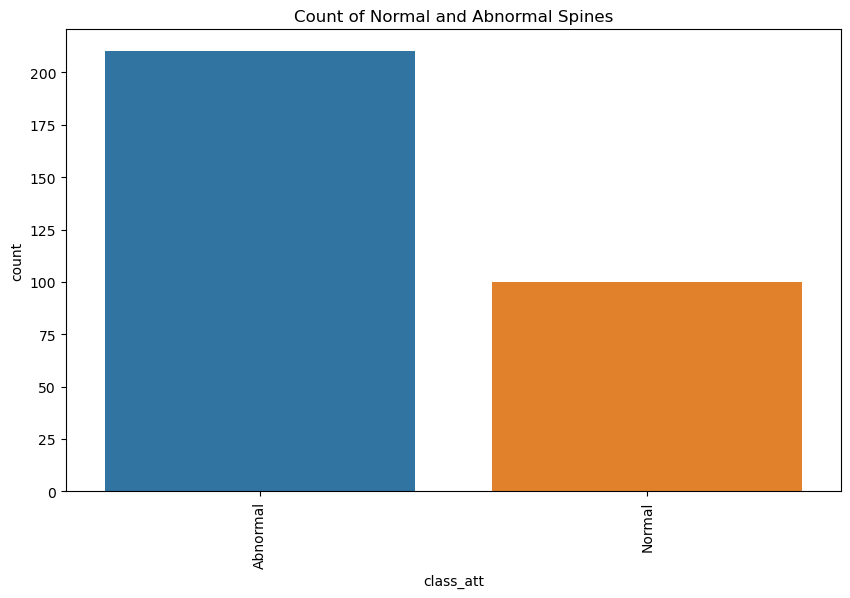

In [79]:
'''
Let's briefly explore the data that we have before we move on to processing our features. 

I'm going to use a Seaborn count plot to see how the data is split across normal spines and abnormal spines. 

You can see that most of the records have some kind of spine abnormality. 
'''
plt.figure(figsize=(10, 6))
plt.title('Count of Normal and Abnormal Spines')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=90)
sns.countplot(x='class_att', data=spine_data)

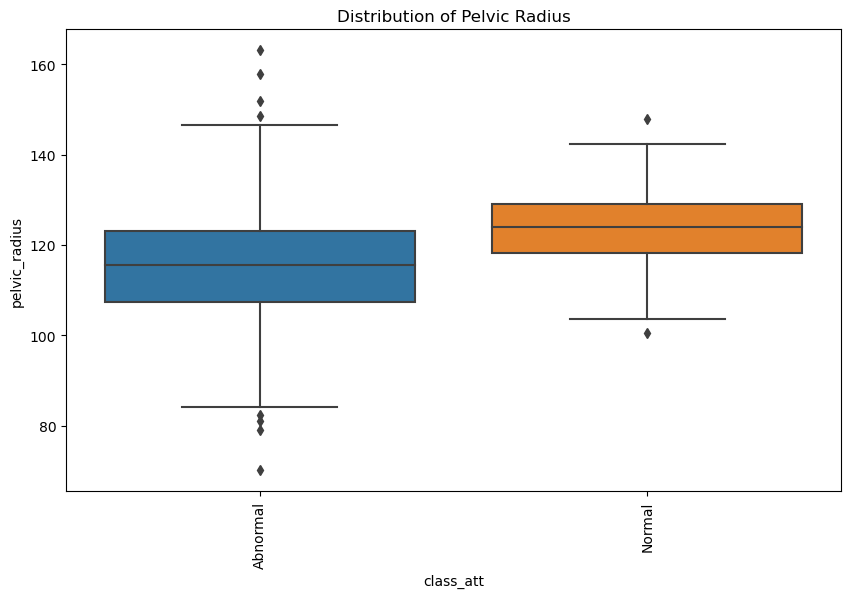

In [80]:
'''
You can also view the distribution of the values for different features based on whether 
the spine is abnormal or normal using a box plot representation. 

It appears from the plot of the pelvic radius here that abnormal spines tend to have a larger reach, 
that is a wider range for pelvic radius, and the pelvic radius overall seems to be smaller. 
'''

plt.figure(figsize=(10, 6))
plt.title('Distribution of Pelvic Radius')
plt.xlabel('Class')
plt.ylabel('Pelvic Radius')
plt.xticks(rotation=90)
sns.boxplot(x='class_att', y='pelvic_radius', data=spine_data)
plt.show()

In [81]:
'''
 All of the features that we'll use to train our model are continuous numeric, but the class attribute 
 is a categorical value. 
 
 So let's encode this using label encoding. We'll use 0 to represent an abnormal 
 spine and 1 to represent a normal spine.
'''

class_att = {'Abnormal': 0, 'Normal': 1}
spine_data['class_att'].replace(class_att, inplace=True)
DisplayMatrix(spine_data[['class_att']].sample(10))

╔═════╦═════════════╗
║     ║   class_att ║
╠═════╬═════════════╣
║ 150 ║           0 ║
╠═════╬═════════════╣
║ 208 ║           0 ║
╠═════╬═════════════╣
║  79 ║           0 ║
╠═════╬═════════════╣
║ 228 ║           0 ║
╠═════╬═════════════╣
║ 250 ║           1 ║
╠═════╬═════════════╣
║ 156 ║           0 ║
╠═════╬═════════════╣
║  72 ║           0 ║
╠═════╬═════════════╣
║   9 ║           0 ║
╠═════╬═════════════╣
║  99 ║           0 ║
╠═════╬═════════════╣
║   5 ║           0 ║
╚═════╩═════════════╝


In [82]:
'''
Extract all of the features or predictors to train our model into the features data frame and 
the target will store in the target data frame. 
'''

features=spine_data.drop('class_att',axis=1)
target=spine_data[['class_att']]

In [83]:
'''
The only processing that we'll do to our features is to standardize them, using the StandardScaler from scikit‑learn.

Invoking fit_transform on the scikit‑learn estimator will standardize our data so that all of 
our numeric features will now have a mean very close to 0, they are now centered around 0, 
and will have a standard deviation close to 1.
'''
standardScaler=StandardScaler()
scaled_features=pd.DataFrame(standardScaler.fit_transform(features),
                             columns=features.columns,
                             index=features.index)
DisplayMatrix(scaled_features.describe().transpose())

╔══════════════════════════╦═════════╦══════════════╦═════════╦═══════════╦═══════════╦════════════╦══════════╦══════════╗
║                          ║   count ║         mean ║     std ║       min ║       25% ║        50% ║      75% ║      max ║
╠══════════════════════════╬═════════╬══════════════╬═════════╬═══════════╬═══════════╬════════════╬══════════╬══════════╣
║ pelvic_incidence         ║     310 ║ -8.02226e-17 ║ 1.00162 ║ -1.99601  ║ -0.817398 ║ -0.104925  ║ 0.719464 ║  4.02921 ║
╠══════════════════════════╬═════════╬══════════════╬═════════╬═══════════╬═══════════╬════════════╬══════════╬══════════╣
║ pelvic tilt              ║     310 ║  2.17747e-16 ║ 1.00162 ║ -2.41166  ║ -0.688114 ║ -0.118606  ║ 0.458116 ║  3.1914  ║
╠══════════════════════════╬═════════╬══════════════╬═════════╬═══════════╬═══════════╬════════════╬══════════╬══════════╣
║ lumbar_lordosis_angle    ║     310 ║  1.71906e-16 ║ 1.00162 ║ -2.04765  ║ -0.806027 ║ -0.127862  ║ 0.597549 ║  3.98461 ║
╠═══════════════

In [84]:

'''
We now have a scaled features data frame holding the predictors for our model. The shape is 310, 12. 
'''
scaled_features.shape

(310, 12)

In [85]:
'''
Let's split this data into training data and test data. We'll use 263 records to train our model, 
the remaining to test our model. 
'''

X_train,X_test,y_train,y_test=train_test_split(scaled_features,
                                               target,
                                               test_size=0.15,
                                               random_state=10)

In [86]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((263, 12), (263, 1), (47, 12), (47, 1))

In [87]:
'''
When we train our model using Keras and TensorFlow, I want to validate the model during the training process. 

I'm going to further split the training data, carve out a portion of this data to use for validation, 
15% of the training data we'll use to validate our model during the training process. 
'''
X_train,X_val,y_train,y_val=train_test_split(X_train,
                                             y_train,
                                            test_size=0.15,
                                            random_state=10)

In [88]:
'''
Finally, here is how our data is split. Training data, validation data during the process of training, 
and test data that we'll use to finally evaluate our model. 
'''
X_train.shape,X_val.shape,X_test.shape

((223, 12), (40, 12), (47, 12))

In [89]:
y_train.shape,y_val.shape,y_test.shape

((223, 1), (40, 1), (47, 1))

In [90]:
X_train.shape[1]

12

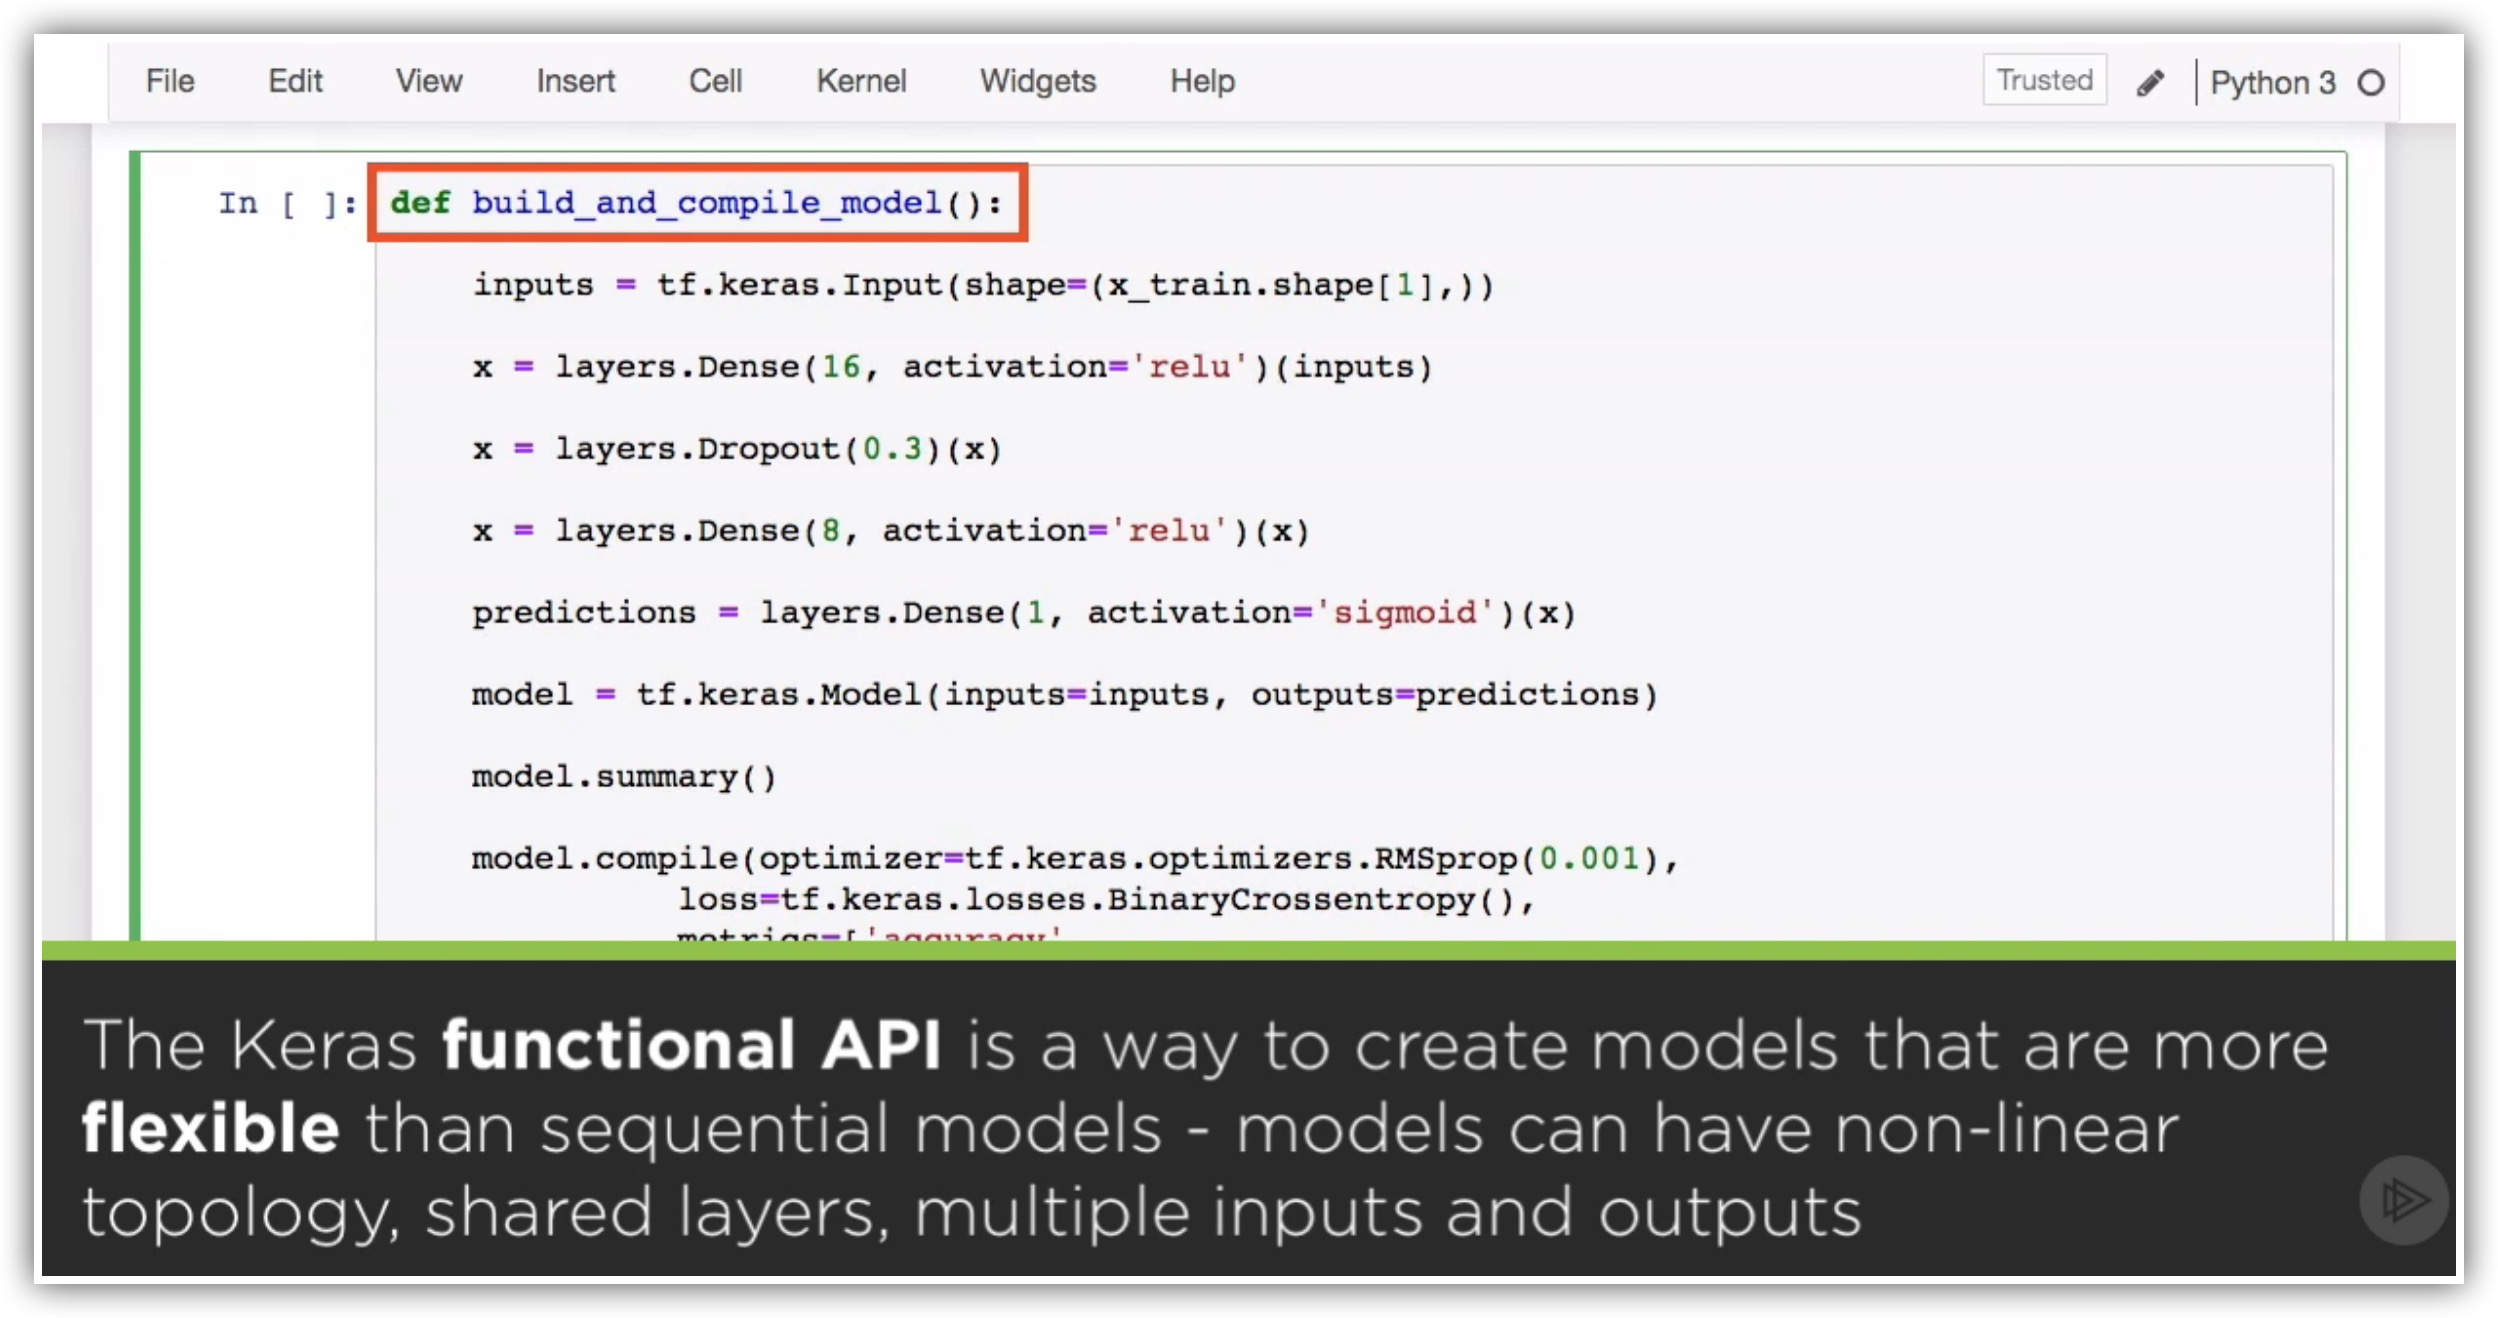

In [91]:
'''
This uses the Keras function API. The function API is a way to create models that are more flexible 
than sequential models, which involve just a stack of layers. 

 Here models can have nonlinear topology, shared layers. 
 You can specify multiple inputs to your models and multiple outputs as well. 

 So if you want more flexibility around how you design your model and how the data flows through your model, 
 you would prefer to use the functional API over the sequential API. 
'''
Image('/Users/subhasish/Development/GIT/Interstellar/SB-AI-DEV/DL/CNN/Pluralsight/Janani Ravi/Build a Machine Learning Workflow with Keras TensorFlow 2.0/SB/Images/2023-05-28_13-20-32.jpg')

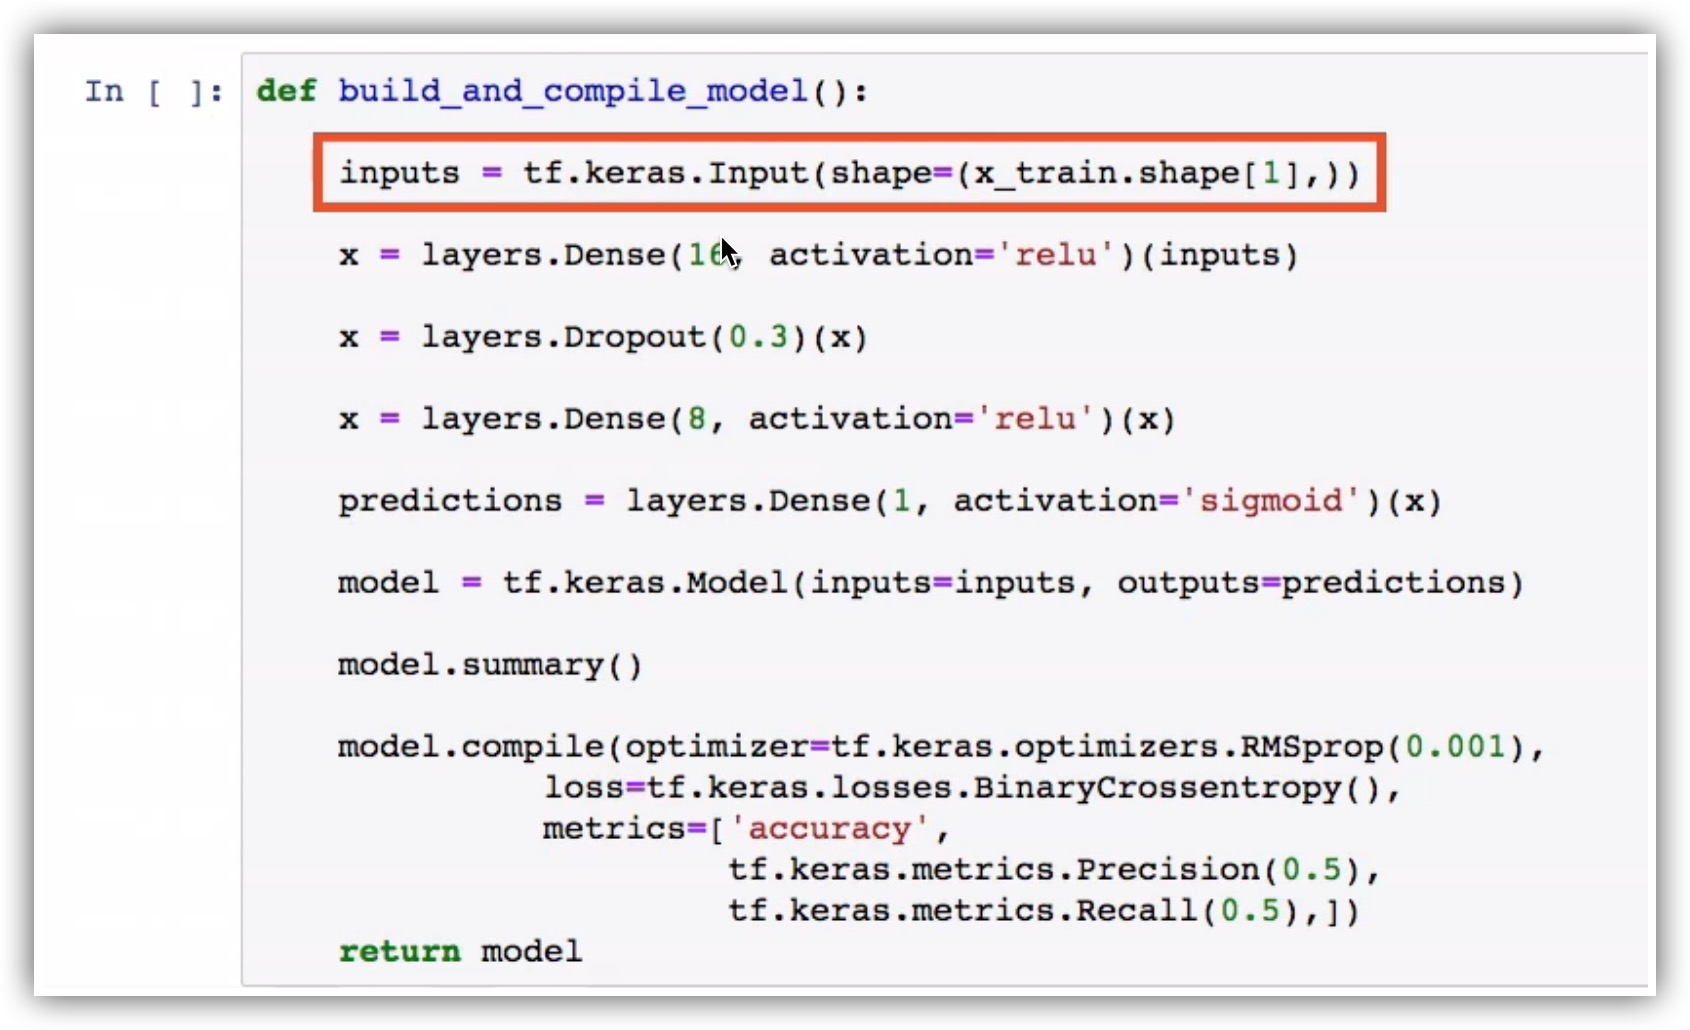

In [92]:
'''
 We'll construct our model here using the functionally API, and the first layer here is an input layer, 
 which we build using tf.keras.Input. 
 
 This takes as an input argument the shape of the layer. That is, the number of features in our input. 

 In the Keras functional API, every layer instance that you instantiate is a callable. 
 This callable accepts inputs and returns a tensor. 
 The input that we've passed in is the input that we had instantiated using the input layer.
'''
Image('/Users/subhasish/Development/GIT/Interstellar/SB-AI-DEV/DL/CNN/Pluralsight/Janani Ravi/Build a Machine Learning Workflow with Keras TensorFlow 2.0/SB/Images/2023-05-28_13-24-12.jpg')

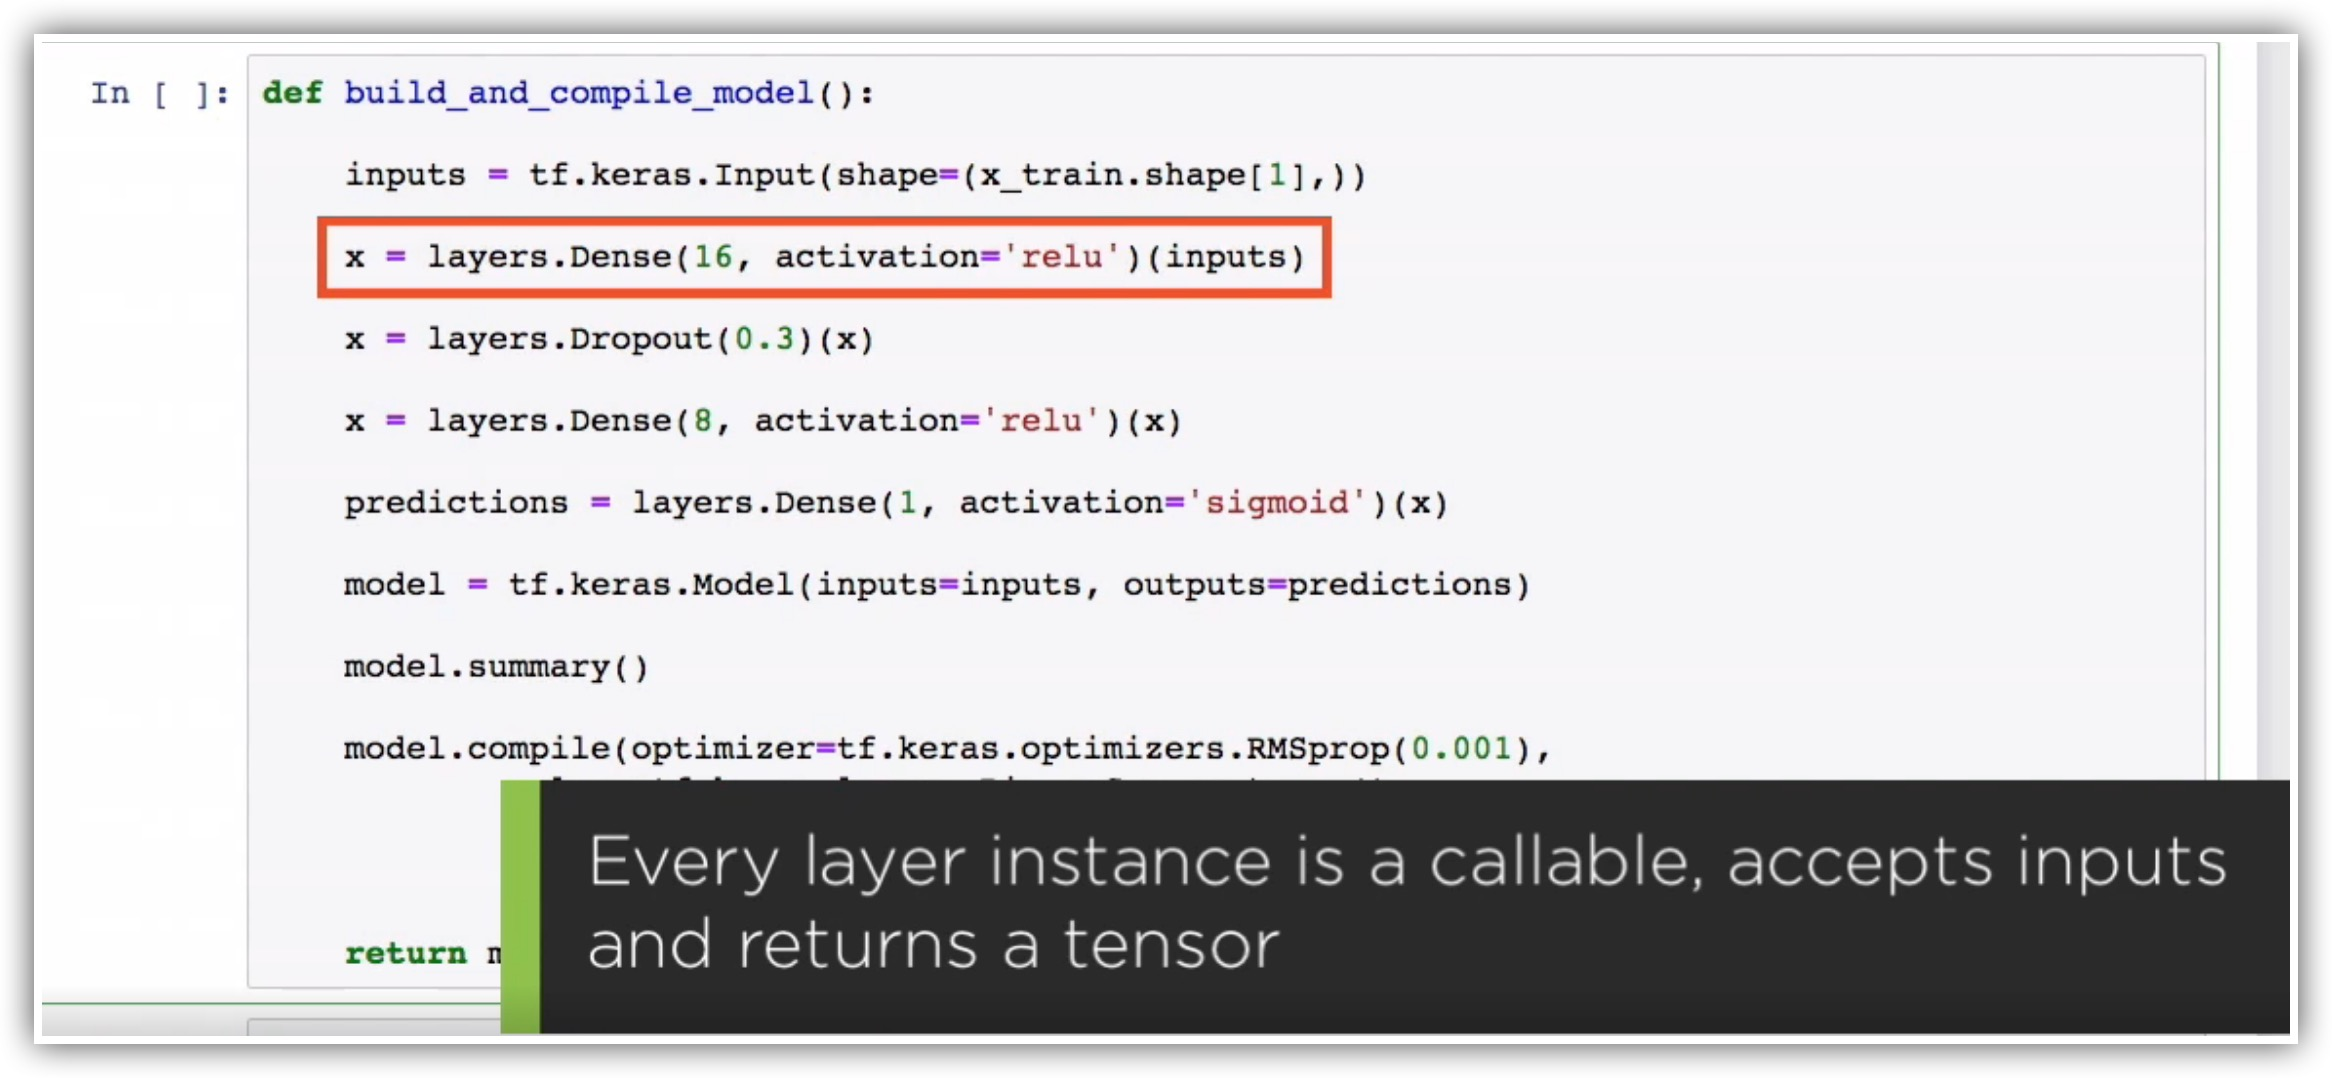

In [93]:
Image('/Users/subhasish/Development/GIT/Interstellar/SB-AI-DEV/DL/CNN/Pluralsight/Janani Ravi/Build a Machine Learning Workflow with Keras TensorFlow 2.0/SB/Images/2023-05-28_13-25-47.jpg')

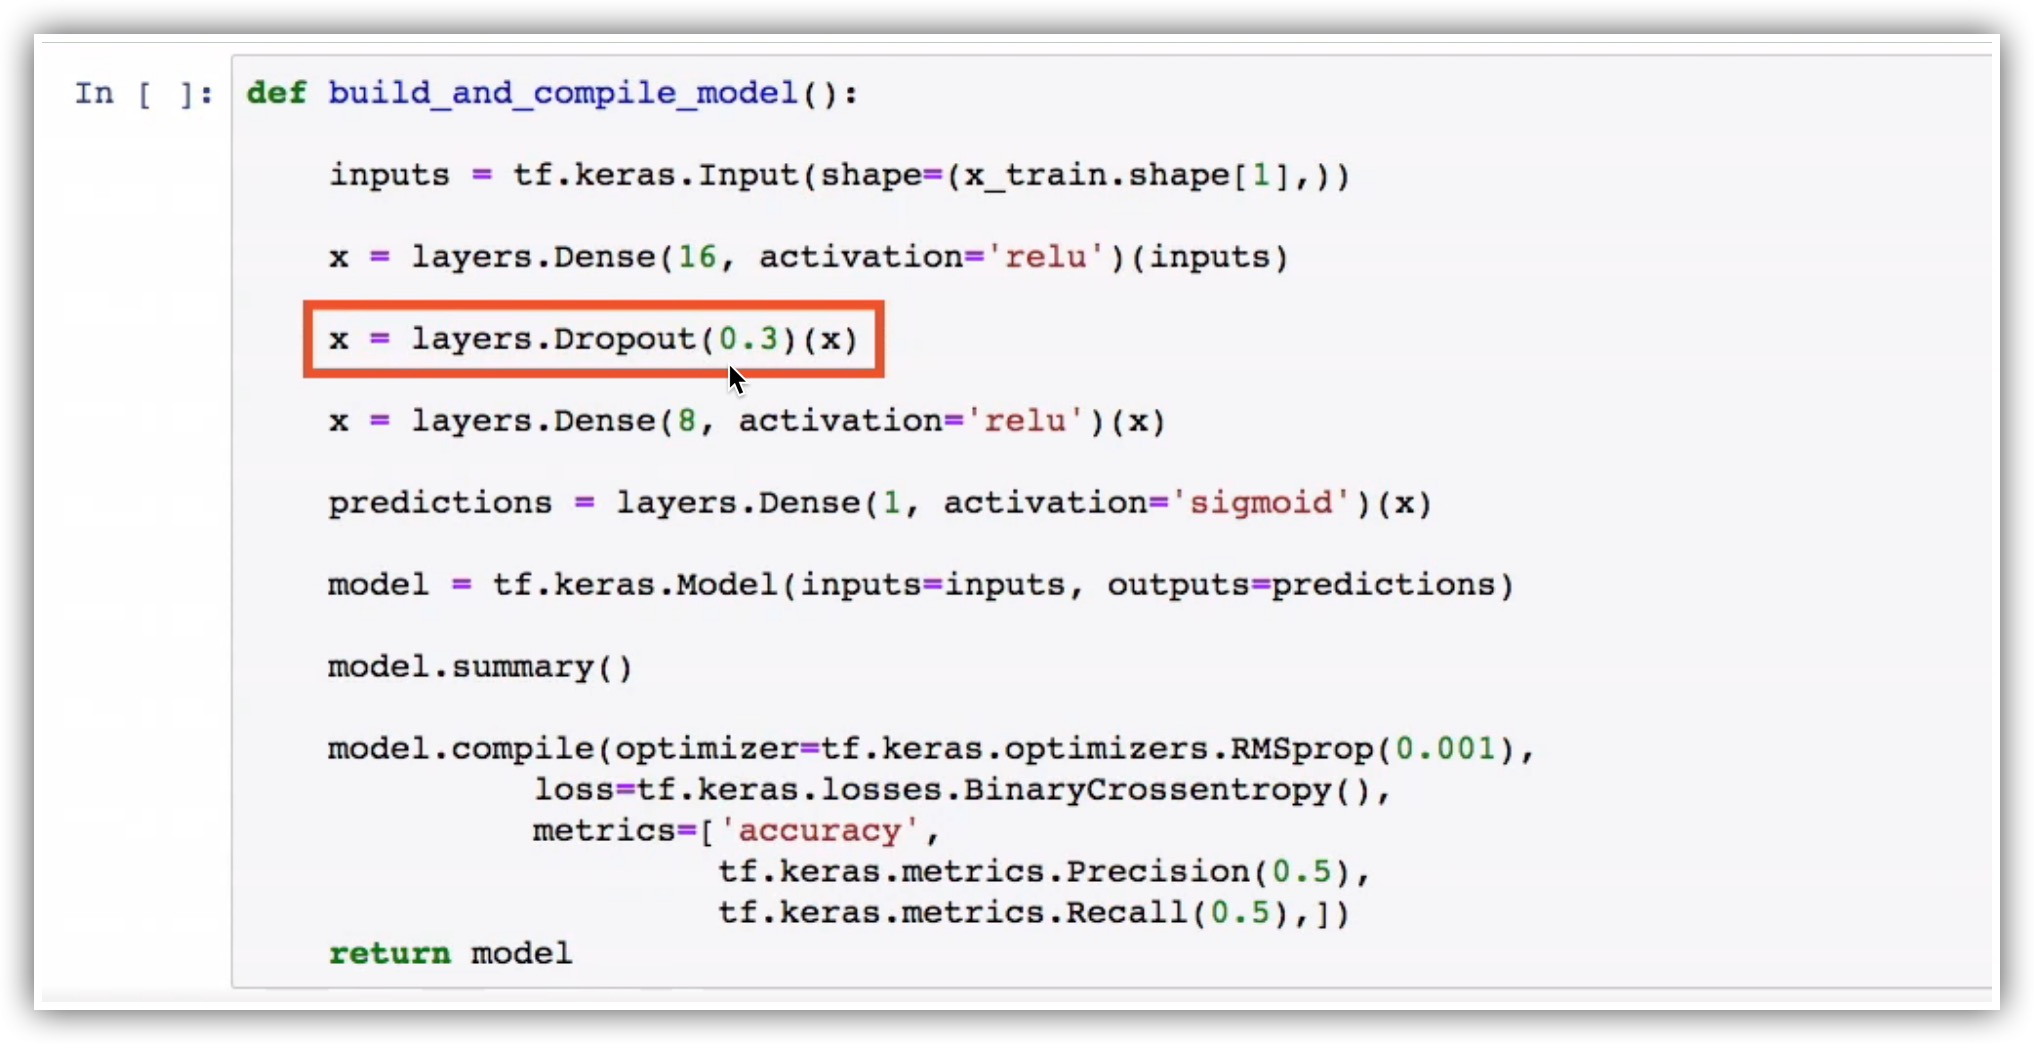

In [94]:
'''
 The next layer is a dropout layer. Once again, notice that we invoke the dropout layer on our x input.
'''
Image('/Users/subhasish/Development/GIT/Interstellar/SB-AI-DEV/DL/CNN/Pluralsight/Janani Ravi/Build a Machine Learning Workflow with Keras TensorFlow 2.0/SB/Images/2023-05-28_13-27-52.jpg')

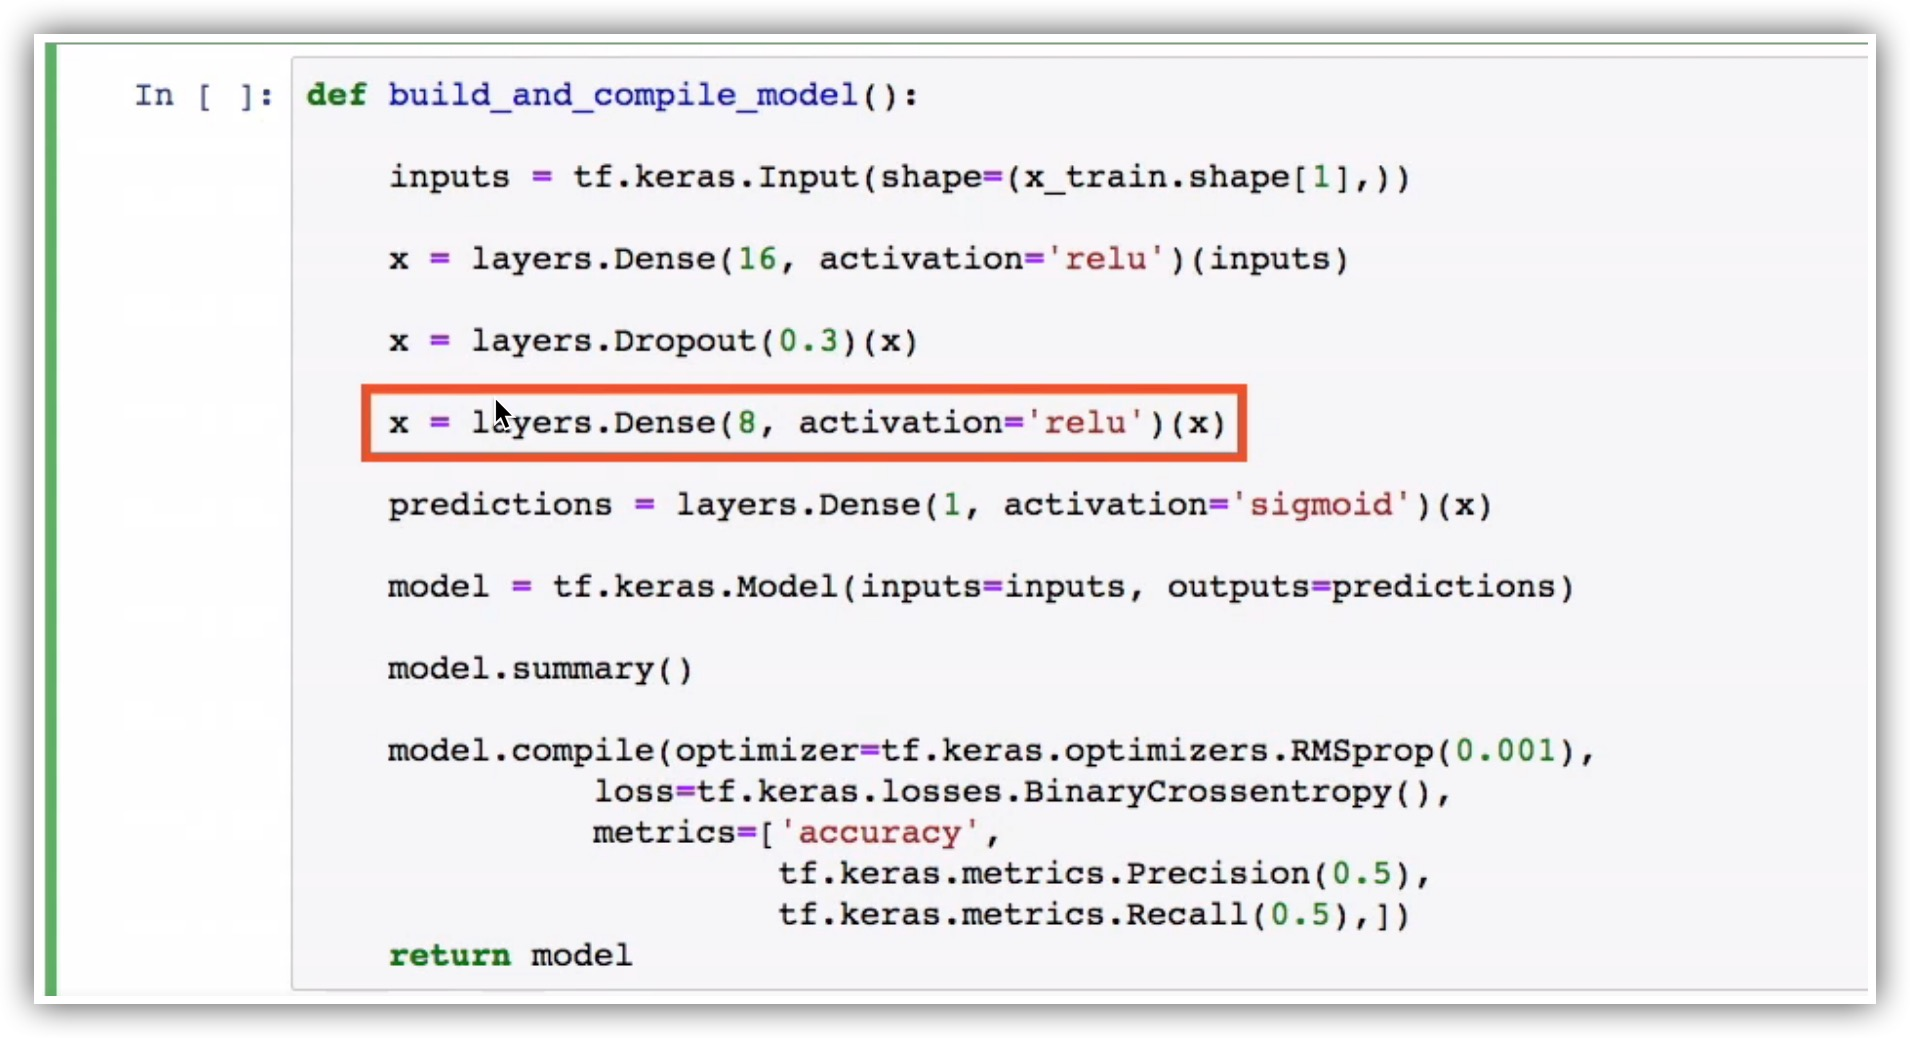

In [95]:
'''
 This dropout layer is followed by a dense layer, that is, a fully connected layer with relu activation. 
 Once again, we invoke this layer on the input.
'''
Image('/Users/subhasish/Development/GIT/Interstellar/SB-AI-DEV/DL/CNN/Pluralsight/Janani Ravi/Build a Machine Learning Workflow with Keras TensorFlow 2.0/SB/Images/2023-05-28_13-30-35.jpg')

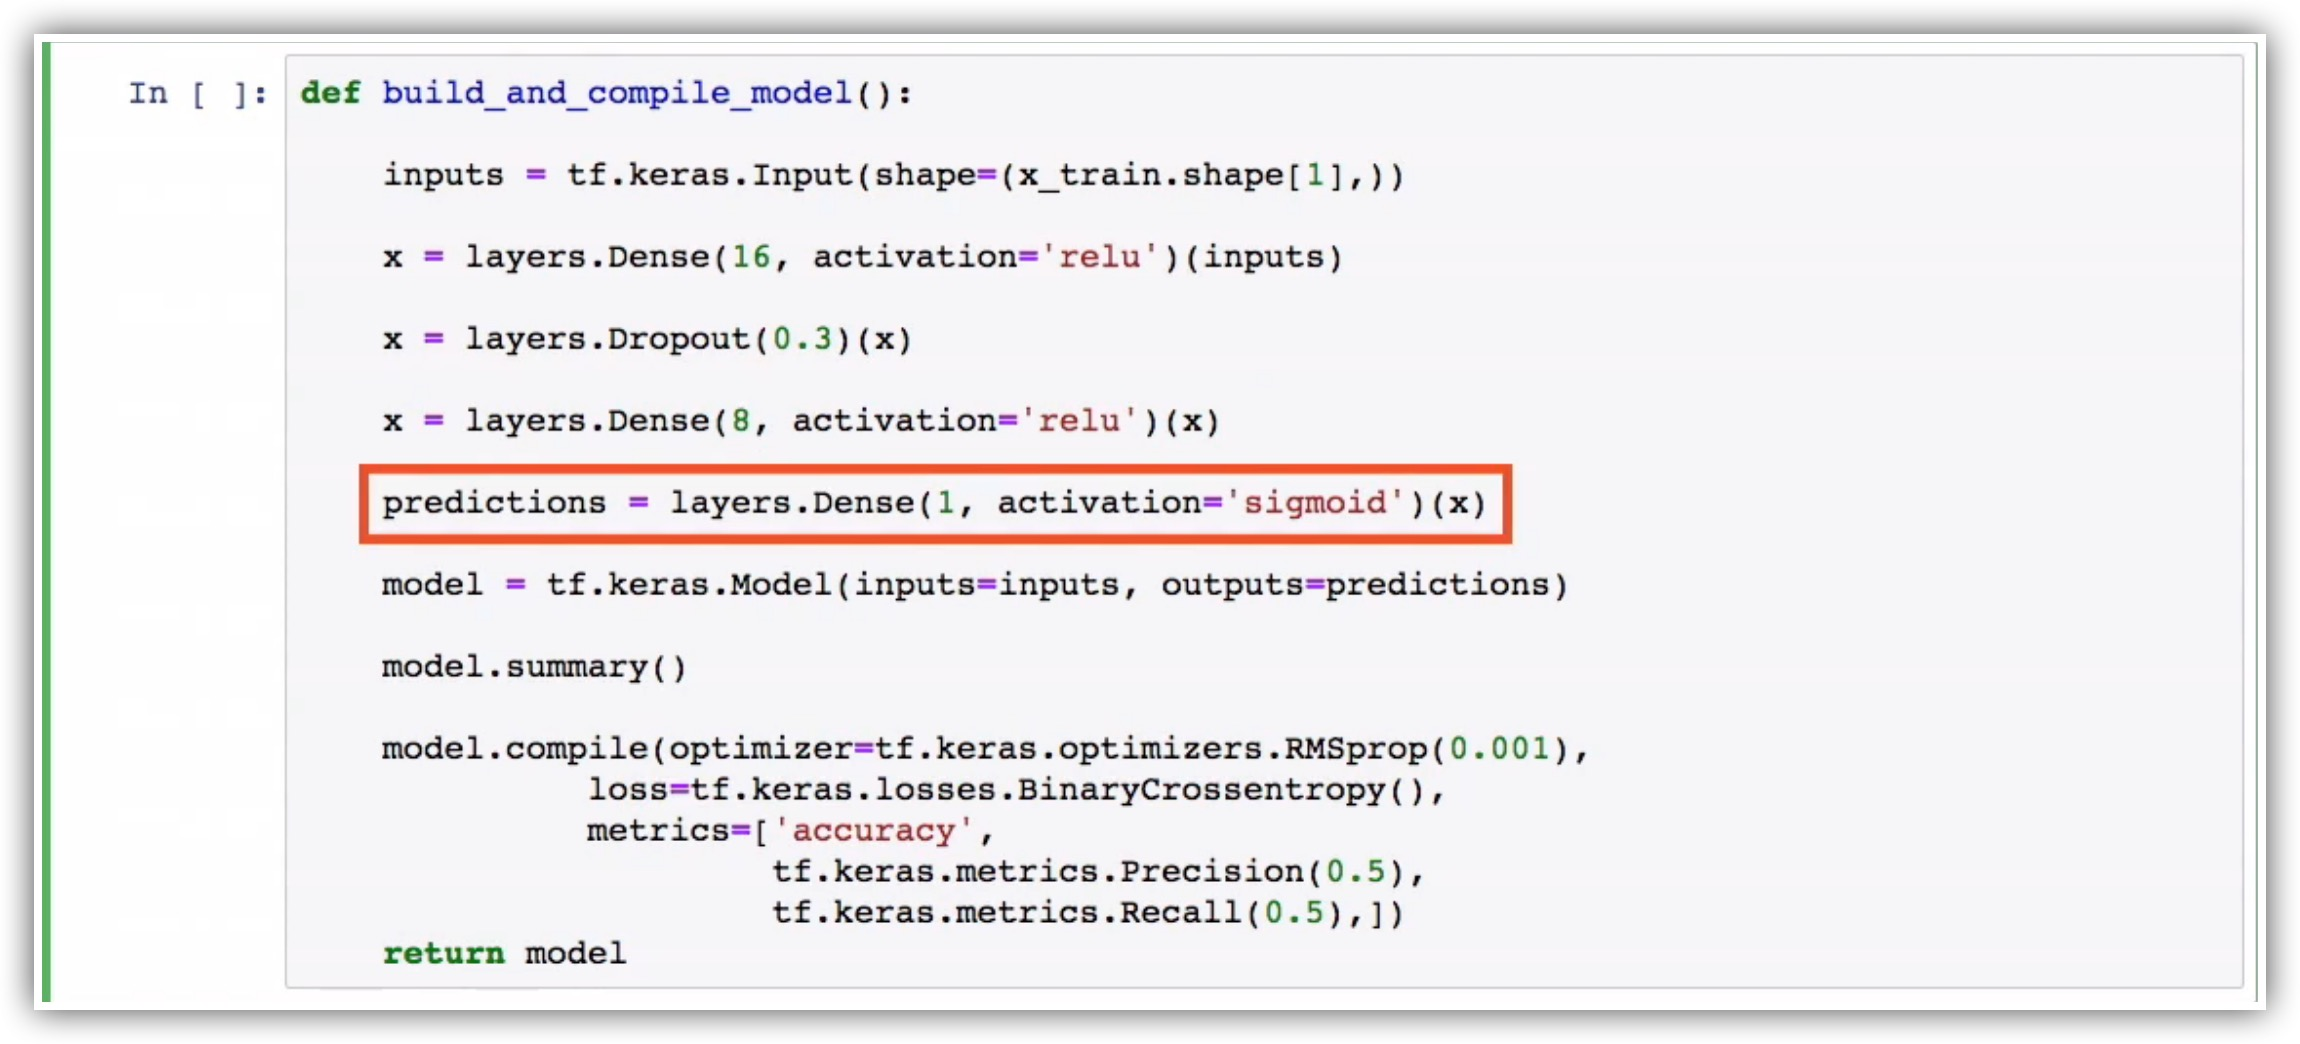

In [96]:
'''
 Our final layer, that is, the predictions layer, is a dense layer with one neuron and sigmoid activation. 
 We invoke this layer on the input in the functional API. 
 The predicted output of our model will be a probability score for the output category‑‑abnormal spine or normal spine.

 We'll use a threshold to determine what the output category will be.
'''
Image('/Users/subhasish/Development/GIT/Interstellar/SB-AI-DEV/DL/CNN/Pluralsight/Janani Ravi/Build a Machine Learning Workflow with Keras TensorFlow 2.0/SB/Images/2023-05-28_13-33-40.jpg')

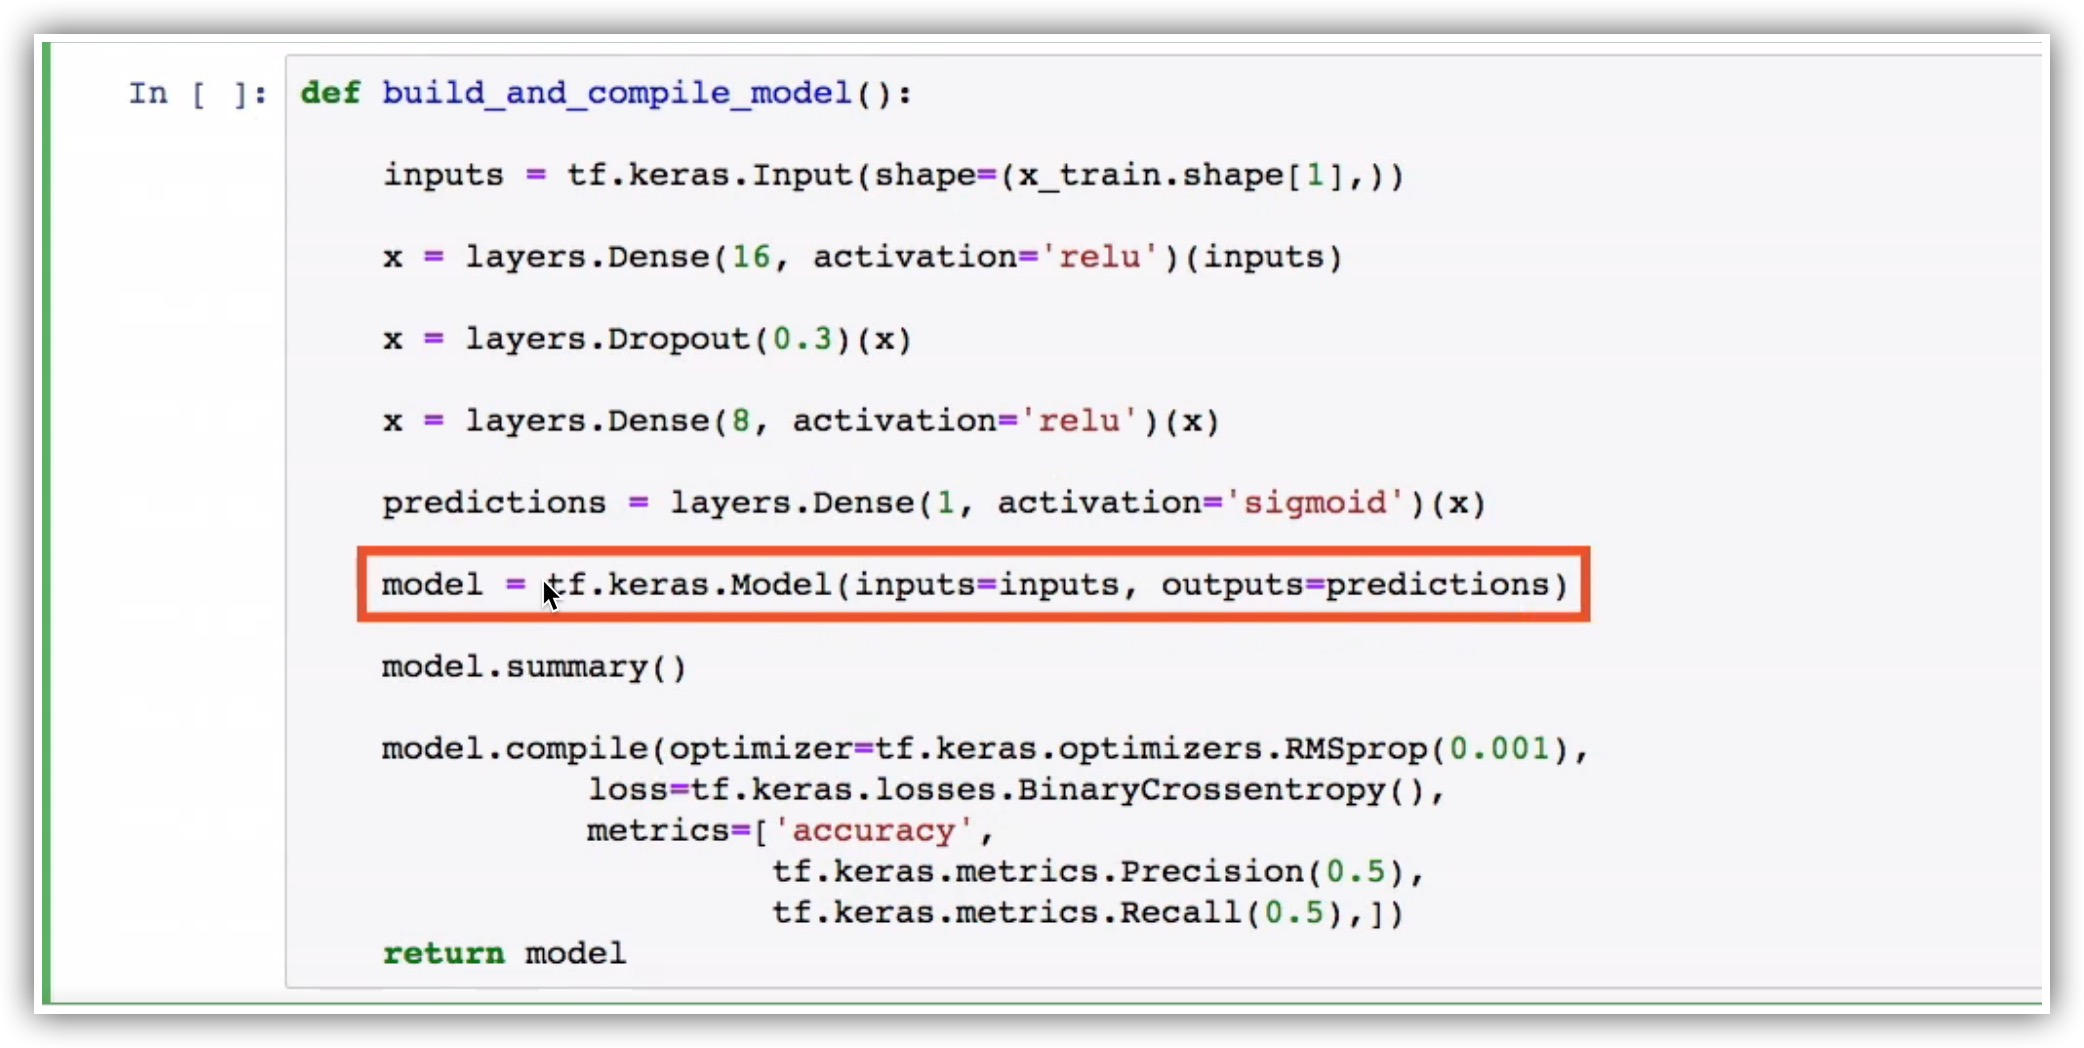

In [97]:
'''
Once we have specified how the data flows through our model using the functional API, 
we can instantiate a model using tf.keras.Model, specify the inputs and the prediction layer of the model.

Having built this model, we'll print out a summary of what this model looks like by invoking model.summary.
'''
Image('/Users/subhasish/Development/GIT/Interstellar/SB-AI-DEV/DL/CNN/Pluralsight/Janani Ravi/Build a Machine Learning Workflow with Keras TensorFlow 2.0/SB/Images/2023-05-28_13-34-13.jpg')

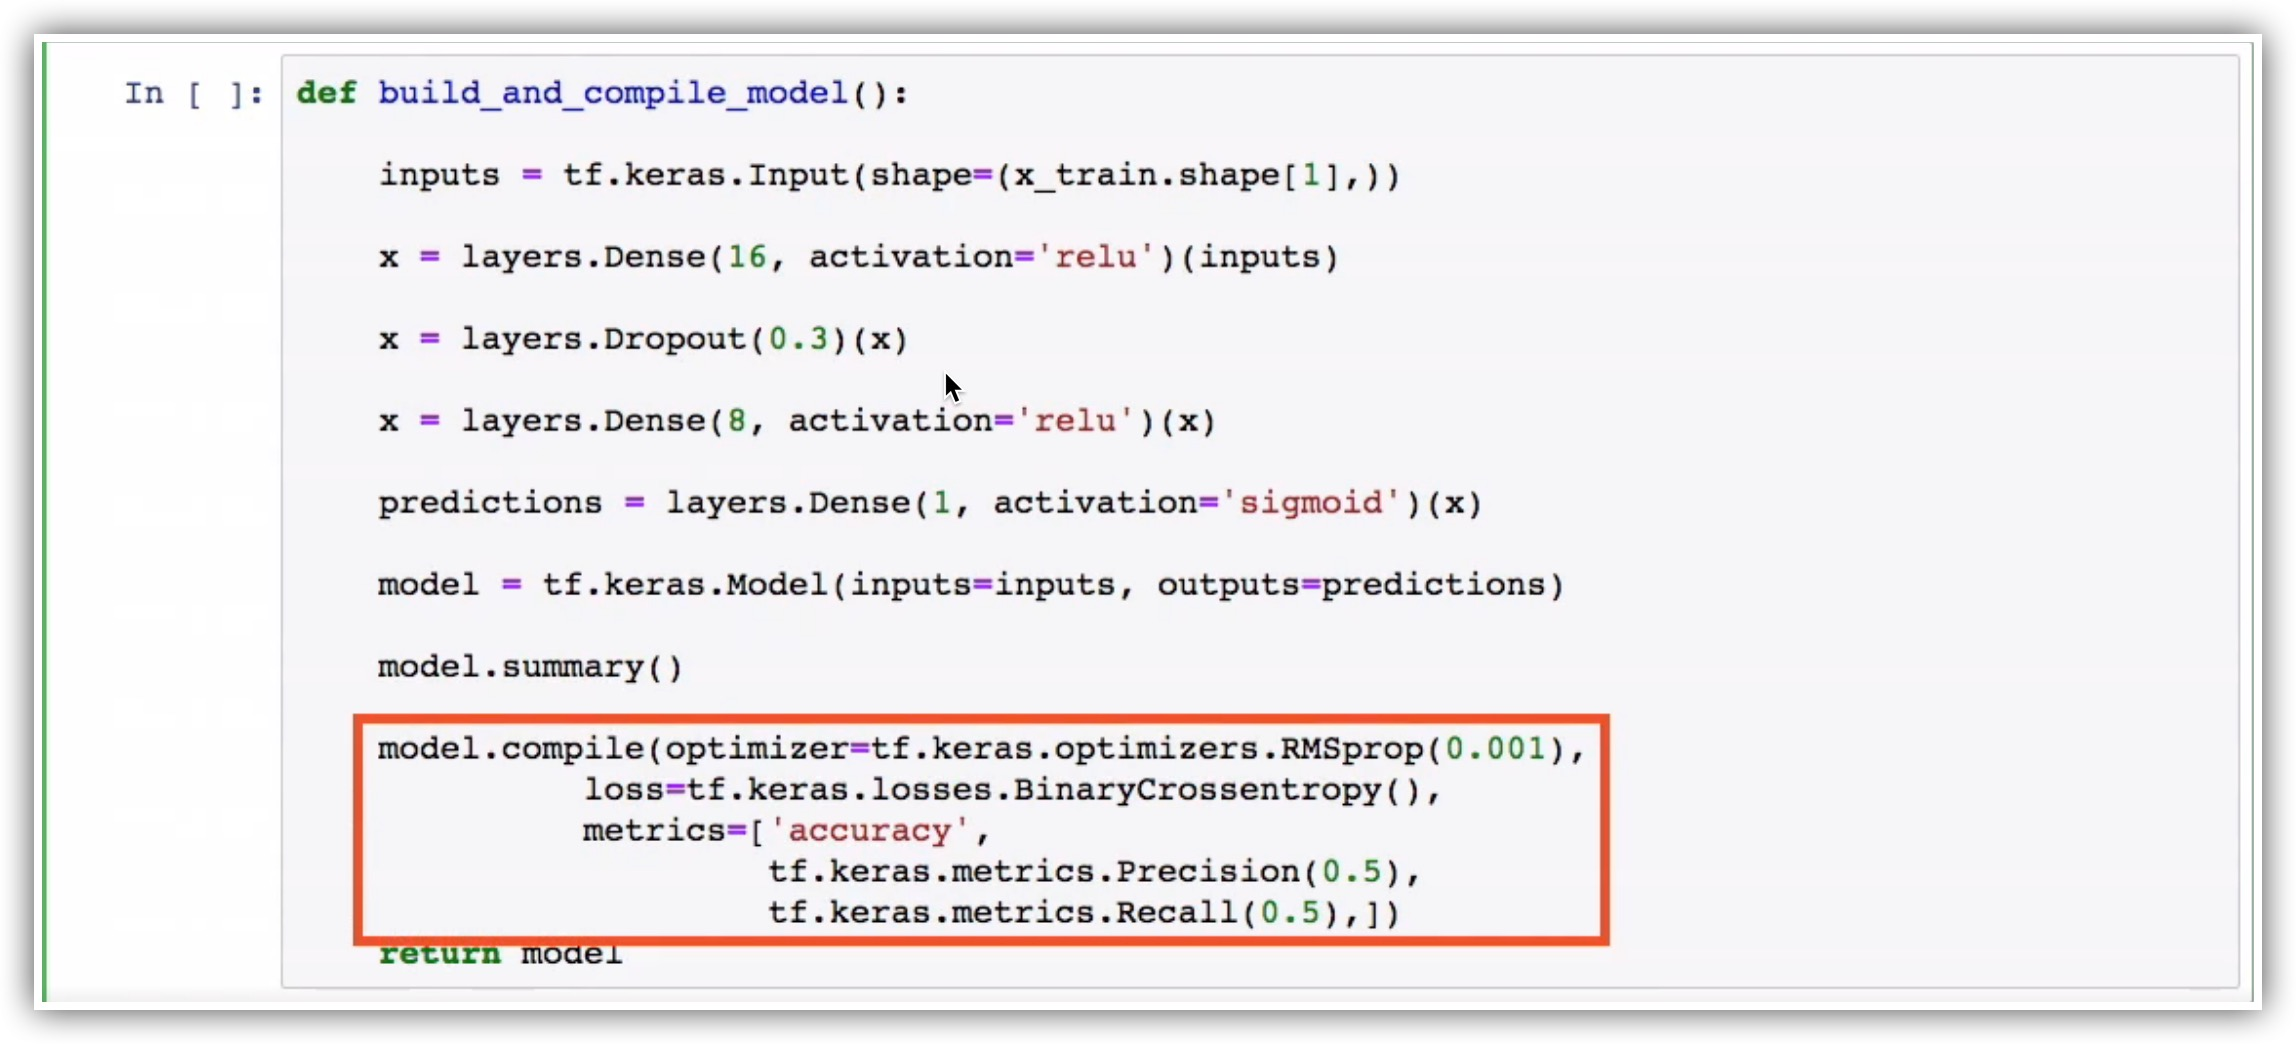

In [98]:
'''
We'll then configure the learning parameters of this model. We'll use the RMSprop optimizer, 
which is an adaptive learning data optimizer. 

We'll use BinaryCrossentropy as the loss function. If your model is a binary classification model, 
that is, the output has two possible categories, this is the loss function that you should use. 

We'll monitor the model using accuracy, precision, and recall, and we'll use 0.5 as the probability 
threshold for both precision and recall. 

Precision and recall are alternative metrics to accuracy that you can use to evaluate your model 
based on your use case. 
Precision tells you how many of the positive identifications of your model have been correctly predicted, 
and recall tells you how many of the positives in your actual data where correctly identified by your model. 
'''
Image('/Users/subhasish/Development/GIT/Interstellar/SB-AI-DEV/DL/CNN/Pluralsight/Janani Ravi/Build a Machine Learning Workflow with Keras TensorFlow 2.0/SB/Images/2023-05-28_13-36-07.jpg')

In [99]:
def build_and_compile_model():
    inputs=tf.keras.Input(shape=(X_train.shape[1],))

    x=layers.Dense(16,activation='relu')(inputs)
    x=layers.Dropout(0.3)(x)
    x=layers.Dense(8,activation='relu')(x)

    outputs=layers.Dense(1,activation='sigmoid')(x)

    model=tf.keras.Model(inputs=inputs,outputs=outputs)

    model.summary()

    model.compile(optimizer=tf.keras.optimizers.RMSprop(0.001),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(0.5),
                           tf.keras.metrics.Recall(0.5)])
    return model

In [100]:
'''
With this utility function set up, you're ready to invoke this function to build and compile a new classification model. 
Here is a quick summary of the model. 
'''
model=build_and_compile_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense (Dense)               (None, 16)                208       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________


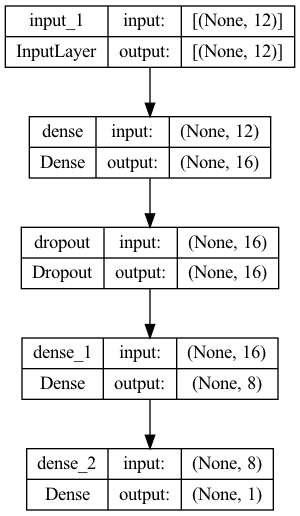

In [101]:
'''
You can also visualize the layers of the model built using the functional API using keras.utils.plot_model. 
Here is the InputLayer that takes in the 12 features in our data that are predictors. 
And here is the final Dense output layer with sigmoid activation. 
'''
keras.utils.plot_model(model,'./model_arc/model_classification_shapes.png',show_shapes=True)

In [102]:
'''
If you're working with TensorFlow using large scale datasets, that's what you do in the real world, 
you won't work with your data in the form of numpy arrays. 

Instead, you'll use the tf.data.Dataset. Converting your model to datasets allows you to train 
your model in a distributed manner using multiple devices. 

We'll create our training dataset from the tensor slices that we have, x_train and y_train.

We want our training data to be fed in batches of 16 records to our model, 
and we'll shuffle our training data using a buffer of size 128. 
'''

dataset_train=tf.data.Dataset.from_tensor_slices((X_train.values,y_train.values))
dataset_train=dataset_train.batch(10)
dataset_train=dataset_train.shuffle(128)

In [103]:
'''
We'll run training for a total of 10 epochs, throw this in a num_epochscalled model.fit, 
and pass in this training dataset. 

Model.fit accepts numpy arrays, as well as dataset objects. 
Model.fit will kick start the training process. 

You can see that accuracy, precision, and recall for our training data is printed to screen. 
This model has a final accuracy of 74.89% on the training data. 

'''
num_epochs=10
model.fit(dataset_train,epochs=num_epochs)

Epoch 1/10


2023-05-28 14:01:36.158976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [223,12]
	 [[{{node Placeholder/_0}}]]
2023-05-28 14:01:36.159311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [223,1]
	 [[{{node Placeholder/_1}}]]


23/23 [==============================] - 1s 1ms/step - loss: 0.6312 - accuracy: 0.6592 - precision: 0.2222 - recall: 0.0282     
Epoch 2/10
23/23 [==============================] - 0s 1ms/step - loss: 0.6069 - accuracy: 0.6682 - precision: 0.2000 - recall: 0.0141    
Epoch 3/10
23/23 [==============================] - 0s 1ms/step - loss: 0.5823 - accuracy: 0.6906 - precision: 0.7500 - recall: 0.0423    
Epoch 4/10
23/23 [==============================] - 0s 1ms/step - loss: 0.5586 - accuracy: 0.6816 - precision: 0.5000 - recall: 0.0141    
Epoch 5/10
23/23 [==============================] - 0s 995us/step - loss: 0.5494 - accuracy: 0.6951 - precision: 1.0000 - recall: 0.0423  
Epoch 6/10
23/23 [==============================] - 0s 1ms/step - loss: 0.5423 - accuracy: 0.6682 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 7/10
23/23 [==============================] - 0s 1ms/step - loss: 0.5196 - accuracy: 0.6726 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 8/10
23/23 [===========

In [104]:
'''
Model.fit can also accept validation data in the form of a dataset. 
'''
dataset_val=tf.data.Dataset.from_tensor_slices((X_val.values,y_val.values))
dataset_val=dataset_val.batch(16)

In [105]:
'''
Create a dataset for our validation data, and let's build and compile a new model. 
We'll invoke model.fit as we did before to run training and pass in the validation data separately 
using a separate input argument. 

Here is the model that we just built, and you can see the training has completed. 
And here is the loss, accuracy, precision, and recall for the training data, as well as the validation data. 
'''
model=build_and_compile_model()
training_history=model.fit(dataset_train,epochs=num_epochs,validation_data=dataset_val)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense_3 (Dense)             (None, 16)                208       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
23/23 [==============================] - 1s 9ms/st

2023-05-28 14:01:38.646425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [40,1]
	 [[{{node Placeholder/_1}}]]


23/23 [==============================] - 0s 2ms/step - loss: 0.7878 - accuracy: 0.5022 - precision_1: 0.2143 - recall_1: 0.2113 - val_loss: 0.6968 - val_accuracy: 0.5250 - val_precision_1: 0.2500 - val_recall_1: 0.1333
Epoch 3/10
23/23 [==============================] - 0s 2ms/step - loss: 0.7420 - accuracy: 0.5381 - precision_1: 0.2143 - recall_1: 0.1690 - val_loss: 0.6635 - val_accuracy: 0.5250 - val_precision_1: 0.2500 - val_recall_1: 0.1333
Epoch 4/10
23/23 [==============================] - 0s 2ms/step - loss: 0.6662 - accuracy: 0.5964 - precision_1: 0.2683 - recall_1: 0.1549 - val_loss: 0.6329 - val_accuracy: 0.5750 - val_precision_1: 0.3333 - val_recall_1: 0.1333
Epoch 5/10
23/23 [==============================] - 0s 2ms/step - loss: 0.6279 - accuracy: 0.6368 - precision_1: 0.2917 - recall_1: 0.0986 - val_loss: 0.6099 - val_accuracy: 0.6250 - val_precision_1: 0.5000 - val_recall_1: 0.1333
Epoch 6/10
23/23 [==============================] - 0s 1ms/step - loss: 0.5780 - accuracy: 

In [106]:
'''
We have the results of the training process in the training history variable. 
If you want to see all of the metrics that are available, you can take a look at the keys.

Here are all of the metrics available, and using this training history, 
you can plot and visualize these metrics using matplotlib, and that's exactly what we'll do next. 
'''
training_history.history.keys()

dict_keys(['loss', 'accuracy', 'precision_1', 'recall_1', 'val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1'])

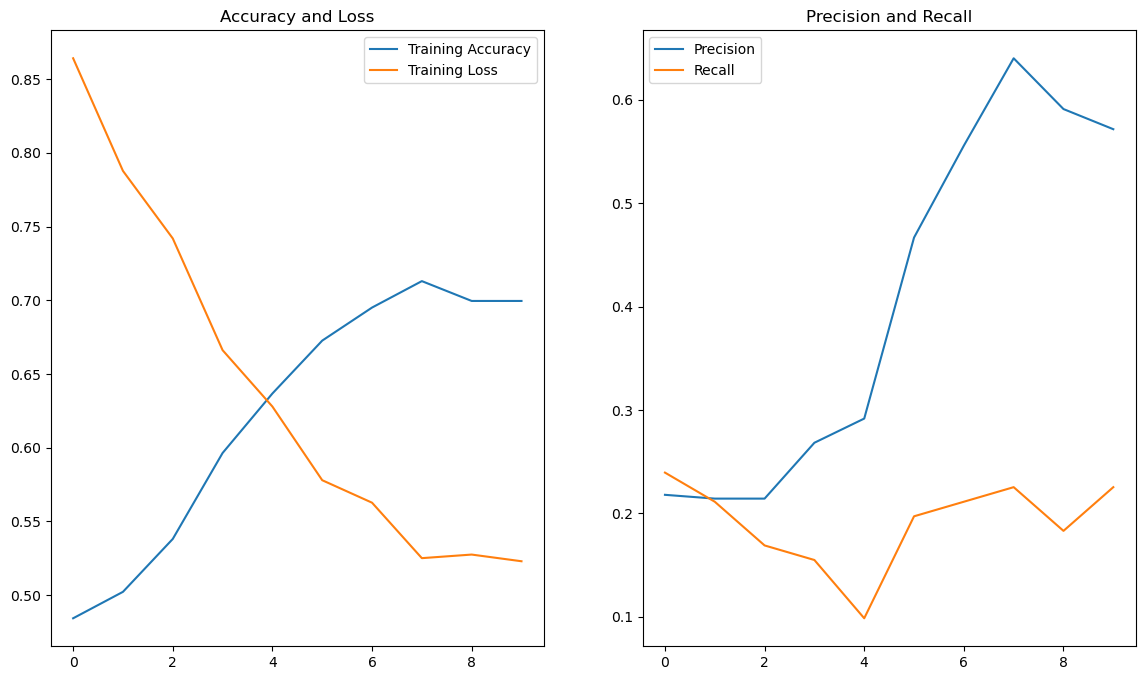

In [107]:
'''
From the training history, we access the accuracy and loss on the training data and plot those. 
We also access the precision and recall on the training data and plot that as well. 
And here is how we can monitor the training process of our model. 

 You can see that training accuracy goes up in the training process, loss falls, 
 and you can see how precision and recall move as well. 
'''
train_acc = training_history.history['accuracy']
train_loss = training_history.history['loss']

precision = training_history.history['precision_1']
recall = training_history.history['recall_1']

epochs_range = range(num_epochs)

plt.figure(figsize=(14, 8))

plt.subplot(1, 2, 1)

plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, train_loss, label='Training Loss')

plt.title('Accuracy and Loss')
plt.legend()

plt.subplot(1, 2, 2)

plt.plot(epochs_range, precision, label='Precision')
plt.plot(epochs_range, recall, label='Recall')

plt.title('Precision and Recall')
plt.legend()

In [109]:
'''
Now that we have a trained model, we can use this model for prediction on our test data. 
Invoke model.predict and store the results in y_pred. 
'''

y_pred=model.predict(X_test)
DisplayMatrix(y_pred[:5])

2/2 [==============================] - 0s 2ms/step
╔═══════════╗
║         0 ║
╠═══════════╣
║ 0.225233  ║
╠═══════════╣
║ 0.385074  ║
╠═══════════╣
║ 0.0254745 ║
╠═══════════╣
║ 0.446223  ║
╠═══════════╣
║ 0.548606  ║
╚═══════════╝


In [112]:
'''
Notice that y_pred now contains probability scores, and we have to apply a threshold to the score to 
calculate the actual predicted categories. 

For probability >= 2.5, we say the spine is normal. Otherwise, we categorize the spine as abnormal. 
'''
import numpy as np
y_pred=np.where(y_pred>=0.5,1,y_pred)
y_pred=np.where(y_pred<0.5,0,y_pred)

In [113]:
'''
Let's take a look at our predicted values. We get 0, 1 values.
'''
DisplayMatrix(y_pred[:5])

╔═════╗
║   0 ║
╠═════╣
║   0 ║
╠═════╣
║   0 ║
╠═════╣
║   0 ║
╠═════╣
║   0 ║
╠═════╣
║   1 ║
╚═════╝


In [114]:
'''
e'll put the predicted results and the actual results in a single data frame. 
This will allow us to compare these side by side.
'''
pred_results=pd.DataFrame({'y_test':y_test.values.flatten(),
                            'y_pred':y_pred.flatten().astype('int32')},
                            index=range(len(y_pred)))

In [126]:
'''
We can then use pd.crosstab to get the confusion matrix of the predicted versus actual results of our model. 
The main diagonal here from the top left to the bottom right gives us those records that have bean accurately 
predicted by our model. 
'''
DisplayMatrix(pd.crosstab(pred_results.y_test,pred_results.y_pred))

╔══════════╦═════╦═════╗
║   y_test ║   0 ║   1 ║
╠══════════╬═════╬═════╣
║        0 ║  29 ║   4 ║
╠══════════╬═════╬═════╣
║        1 ║  10 ║   4 ║
╚══════════╩═════╩═════╝


In [123]:
'''
Let's calculate the accuracy score. It's 72.3%. 
'''
accuracy_score(y_test,y_pred)

0.7021276595744681

In [124]:
'''
The precision of our model is 50%. That is the proportion of spines identified us normal by our model. 
We're 50% accurate. 
'''
precision_score(y_test,y_pred)

0.5

In [125]:
'''
Let's take a look at the recall here. 
That's 23%; 23% of the normal spines in the test data were correctly identified by our model.
'''
recall_score(y_test,y_pred)

0.2857142857142857

In [129]:
'''
When your training data is extremely large, it's quite possible that your training process will run for a long time. 
It's useful to checkpoint your model at certain epochs so that if training fails at some point, 
you always can roll back and start training from a checkpoint.

Here we'll see how we can use a callback to checkpoint our model during the training process. 

Set up a checkpoint directory under my_models/spine_classification. 
Use this directory to initialize a model checkpoint callback. 

 We'll specify that during the training process our model should be 
 checkpointed every three epochs, save_frequency equal to 3.

 In addition, for each checkpoint, we won't save the architecture of the model. 
 We'll only save the weights of the model, save_weights_only equal to True.

  Using this callback, we've completely automated the process of checkpointing our model.  
'''

ckpt_path='./models/spine_classification'
ckpt_dir=os.path.dirname(ckpt_path)

ckpt_callback=tf.keras.callbacks.ModelCheckpoint(filepath=ckpt_path,
                                                save_weights_only=True,
                                                save_freq=3,
                                                verbose=False)



In [130]:
'''
Let's build a new model and call fit on our training data. 
Make sure you pass in this ckpt_callback to the fit function of your model. 

Now go ahead, run the training process, and your model will take care of check pointing 
automatically every three epochs. 

The weights of your model will be saved under my_models and 
the directory that we specified, spine_classification. 
'''
model=build_and_compile_model()
model.fit(dataset_train,
          epochs=num_epochs,
          validation_data=dataset_val,
          verbose=False,
          callbacks=[ckpt_callback])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense (Dense)               (None, 16)                208       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________


In [135]:
!ls ./models

checkpoint
elu_64_early_stopping
elu_64_early_stopping_config.json
elu_64_early_stopping_weights.data-00000-of-00001
elu_64_early_stopping_weights.h5
elu_64_early_stopping_weights.index
spine_classification.data-00000-of-00001
spine_classification.index


In [136]:
'''
Now that we have a trained model, let's quickly use this model for prediction on the test data. 
We'll get the predicted values by using the threshold as we did before. 
The accuracy of this model is around 70%. 
'''

y_pred=model.predict(X_test)
y_pred=np.where(y_pred>=0.5,1,y_pred)
y_pred=np.where(y_pred<0.5,0,y_pred)
accuracy_score(y_test,y_pred)

2/2 [==============================] - 0s 2ms/step


0.7021276595744681

In [137]:
'''
We'll now see how we can reload our model using checkpointed feeds. 

I'm going to reinitialize the model architecture by calling build_and_compile_model and invoke 
the load_weights function and specify the checkpoint path. 

This reloaded model will contain the weights loaded using the last saved checkpoint, 
the system model that we've been working with. 
'''
reloaded_model=build_and_compile_model()
reloaded_model.load_weights(ckpt_path)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense_3 (Dense)             (None, 16)                208       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________


In [138]:
'''
We can confirm that this reloaded model has the same parameters as the original model by predicting 
on the test data and calculating the accuracy score. 

The accuracy score that we get is exactly the same, roughly 70.2. 
'''
y_pred=reloaded_model.predict(X_test)
y_pred=np.where(y_pred>=0.5,1,y_pred)
y_pred=np.where(y_pred<0.5,0,y_pred)
accuracy_score(y_test,y_pred)

2/2 [==============================] - 0s 2ms/step


0.7021276595744681

In [144]:
'''
Now, let's continue the training process for this data from this checkpoint. 

All you need to do is invoke the fit function, and it'll continue training the model from the last saved weight. 
We'll train this model for five more epochs. Hopefully, this has improved the performance of our model. 
'''

reloaded_model.fit(dataset_train,
                    epochs=5,
                    validation_data=dataset_val)


Epoch 1/5
23/23 [==============================] - 0s 3ms/step - loss: 0.3912 - accuracy: 0.8386 - precision_1: 0.7692 - recall_1: 0.7042 - val_loss: 0.6584 - val_accuracy: 0.7750 - val_precision_1: 0.8000 - val_recall_1: 0.5333
Epoch 2/5
23/23 [==============================] - 0s 3ms/step - loss: 0.3745 - accuracy: 0.8341 - precision_1: 0.7931 - recall_1: 0.6479 - val_loss: 0.6576 - val_accuracy: 0.7750 - val_precision_1: 0.8000 - val_recall_1: 0.5333
Epoch 3/5
23/23 [==============================] - 0s 4ms/step - loss: 0.3676 - accuracy: 0.8520 - precision_1: 0.7969 - recall_1: 0.7183 - val_loss: 0.6560 - val_accuracy: 0.7750 - val_precision_1: 0.8000 - val_recall_1: 0.5333
Epoch 4/5
23/23 [==============================] - 0s 5ms/step - loss: 0.3523 - accuracy: 0.8475 - precision_1: 0.8246 - recall_1: 0.6620 - val_loss: 0.6616 - val_accuracy: 0.7500 - val_precision_1: 0.7273 - val_recall_1: 0.5333
Epoch 5/5
23/23 [==============================] - 0s 3ms/step - loss: 0.3762 - accu

In [145]:
'''
We'll call predict on the test data using this model that has been trained for 
10 epochs previously and then 5 more epochs after we reloaded the model from the checkpoint. 

And you can see that the accuracy of the model has improved. It's now close to 76%.
'''

y_pred=reloaded_model.predict(X_test)
y_pred=np.where(y_pred>=0.5,1,y_pred)
y_pred=np.where(y_pred<0.5,0,y_pred)
accuracy_score(y_test,y_pred)

2/2 [==============================] - 0s 2ms/step


0.7659574468085106

In [149]:
'''
Before we are done with this classification model, let's see how we can use TensorBoard to monitor this model. 

You simply have to specify a logs directory where you want your logs to be stored 
and instantiate a TensorBoard callback. 

TensorBoard is TensorFlow's visualization toolkit, and it allows you to track and 
visualize metrics during the training process of your model metrics, such as loss and accuracy.

It can visualize the modell graph, and there are a number of other options available. 
When we install the TensorFlow libraries using pip install, TensorBoard comes along with it.

I'm going to run TensorBoard with a histogram frequency of 1. 


'''

log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [150]:
'''
That is every epoch. Our TensorBoard points to the logs directory where logs will be collected. 
Make sure you specify this TensorBoard callback. 
Make sure you pass in the tensorboard_callback to model.fit and start the process of training your model. 
'''
model.fit(dataset_train, 
          epochs=num_epochs, 
          validation_data=dataset_val,
          verbose=False,
          callbacks=[tensorboard_callback])

In [153]:
'''
Once your model has been trained, you can visualize the training process using 
the TensorBoard extension available within Jupyter notebooks. 

Load this extension in using the load_ext magic function, 
load_ext tensorboard, and call tensorboard ‑‑ and specify the logs directory. 
'''
%reload_ext tensorboard
%tensorboard --logdir logs

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the server with a different port.

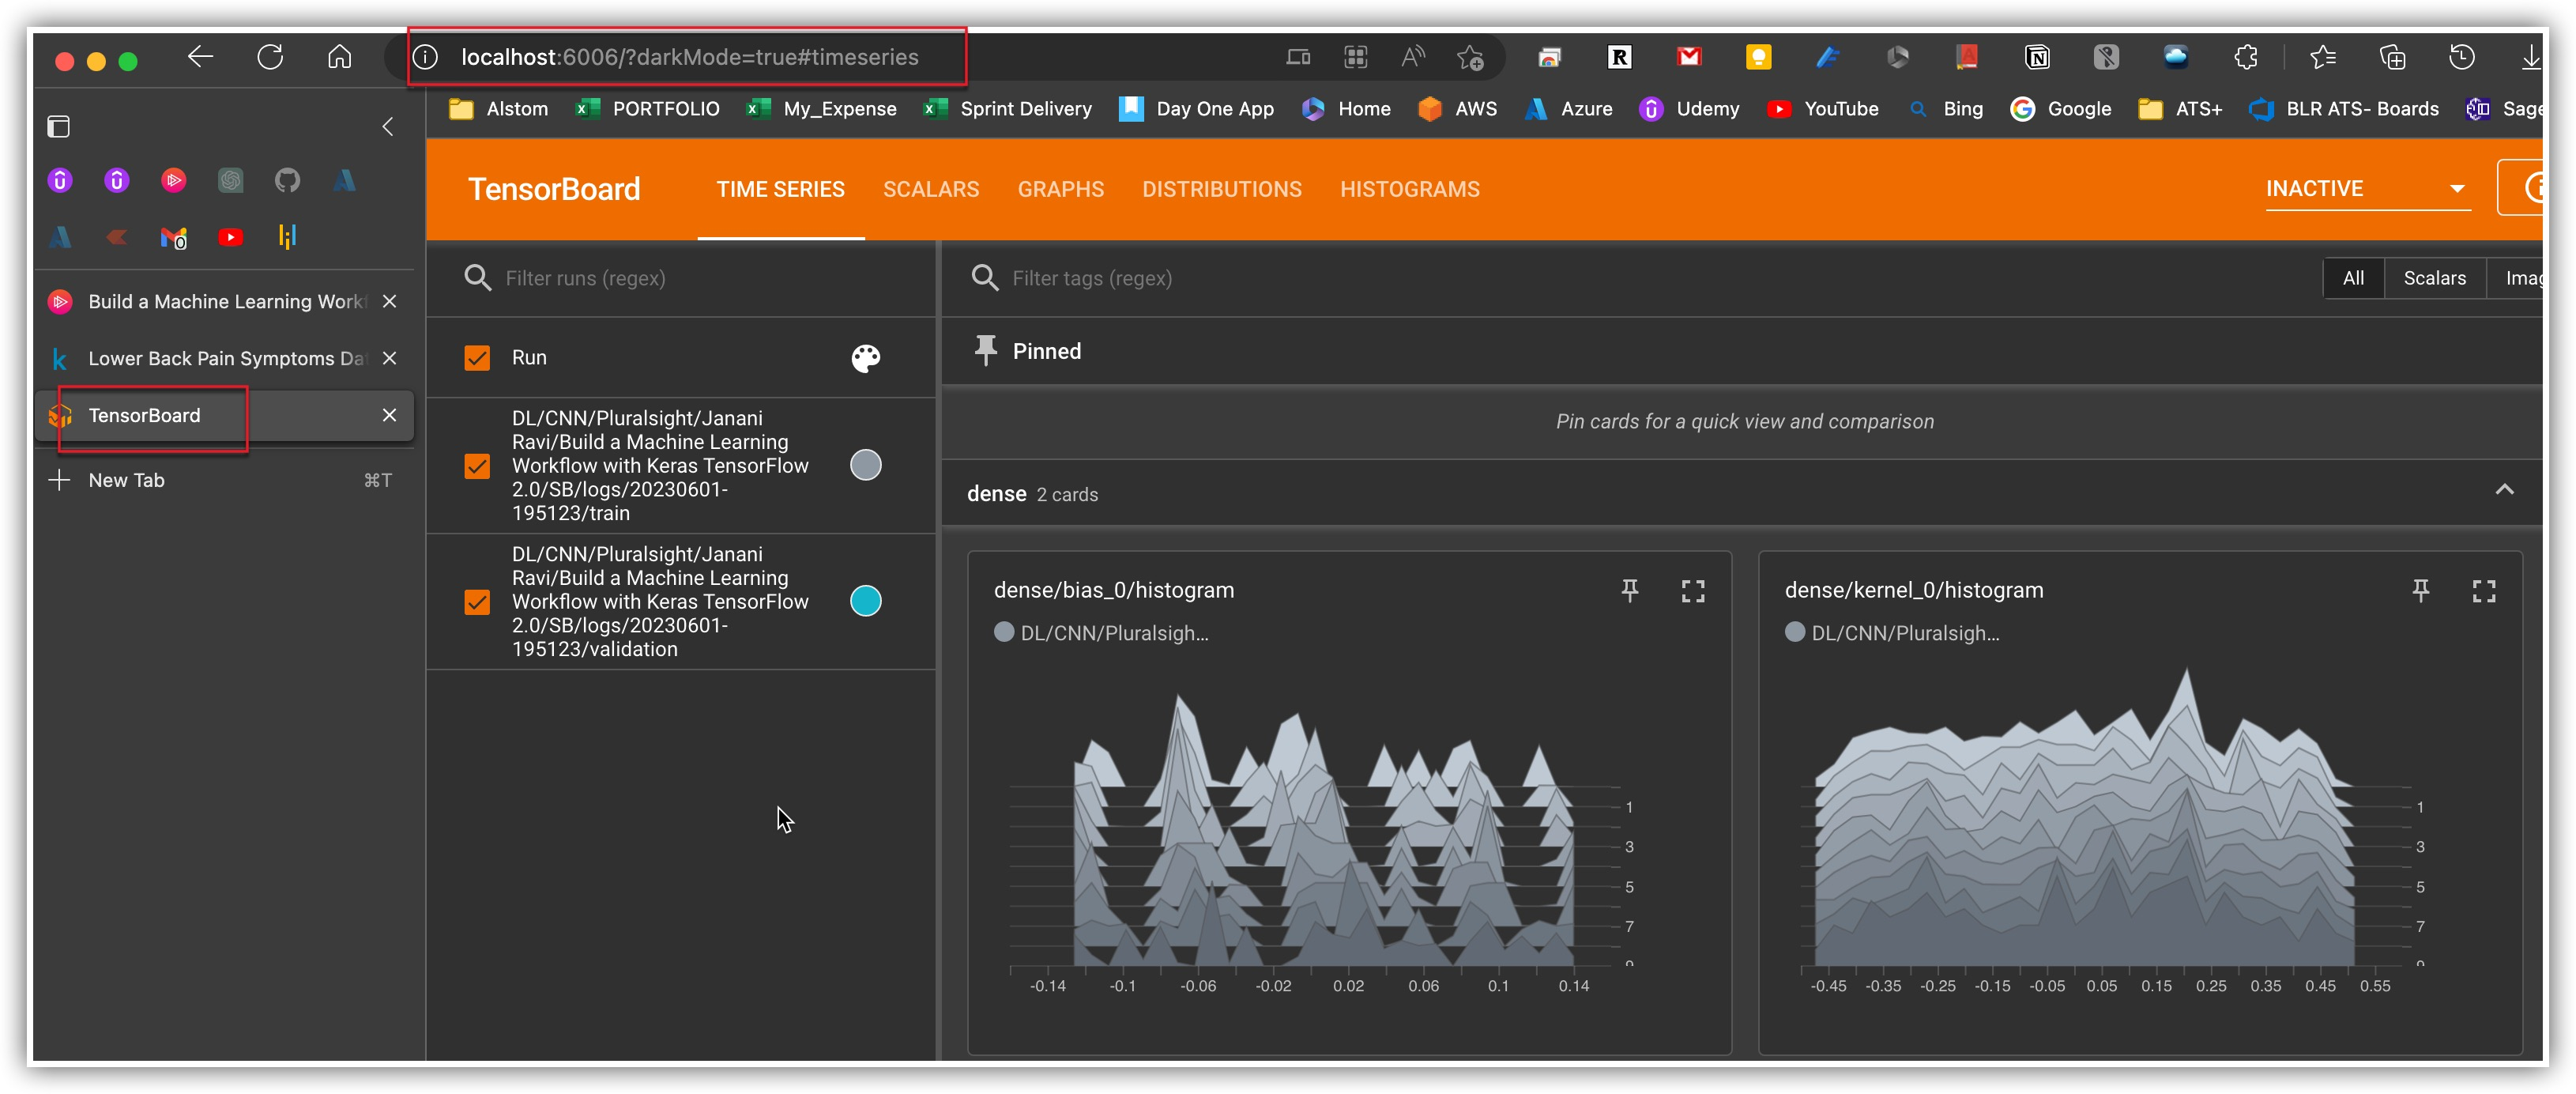

In [154]:
'''
This will embed the TensorFlow visualization right within your Jupyter Notebook. Now having 
it embedded is convenient, but this is rather slow. 

I'd rather work with TensorBoard directly on a separate browser window, and that's exactly what we'll do now. 
'''

Image('/Users/subhasish/Development/GIT/Interstellar/SB-AI-DEV/DL/CNN/Pluralsight/Janani Ravi/Build a Machine Learning Workflow with Keras TensorFlow 2.0/SB/Images/2023-06-01_20-30-12.jpg')

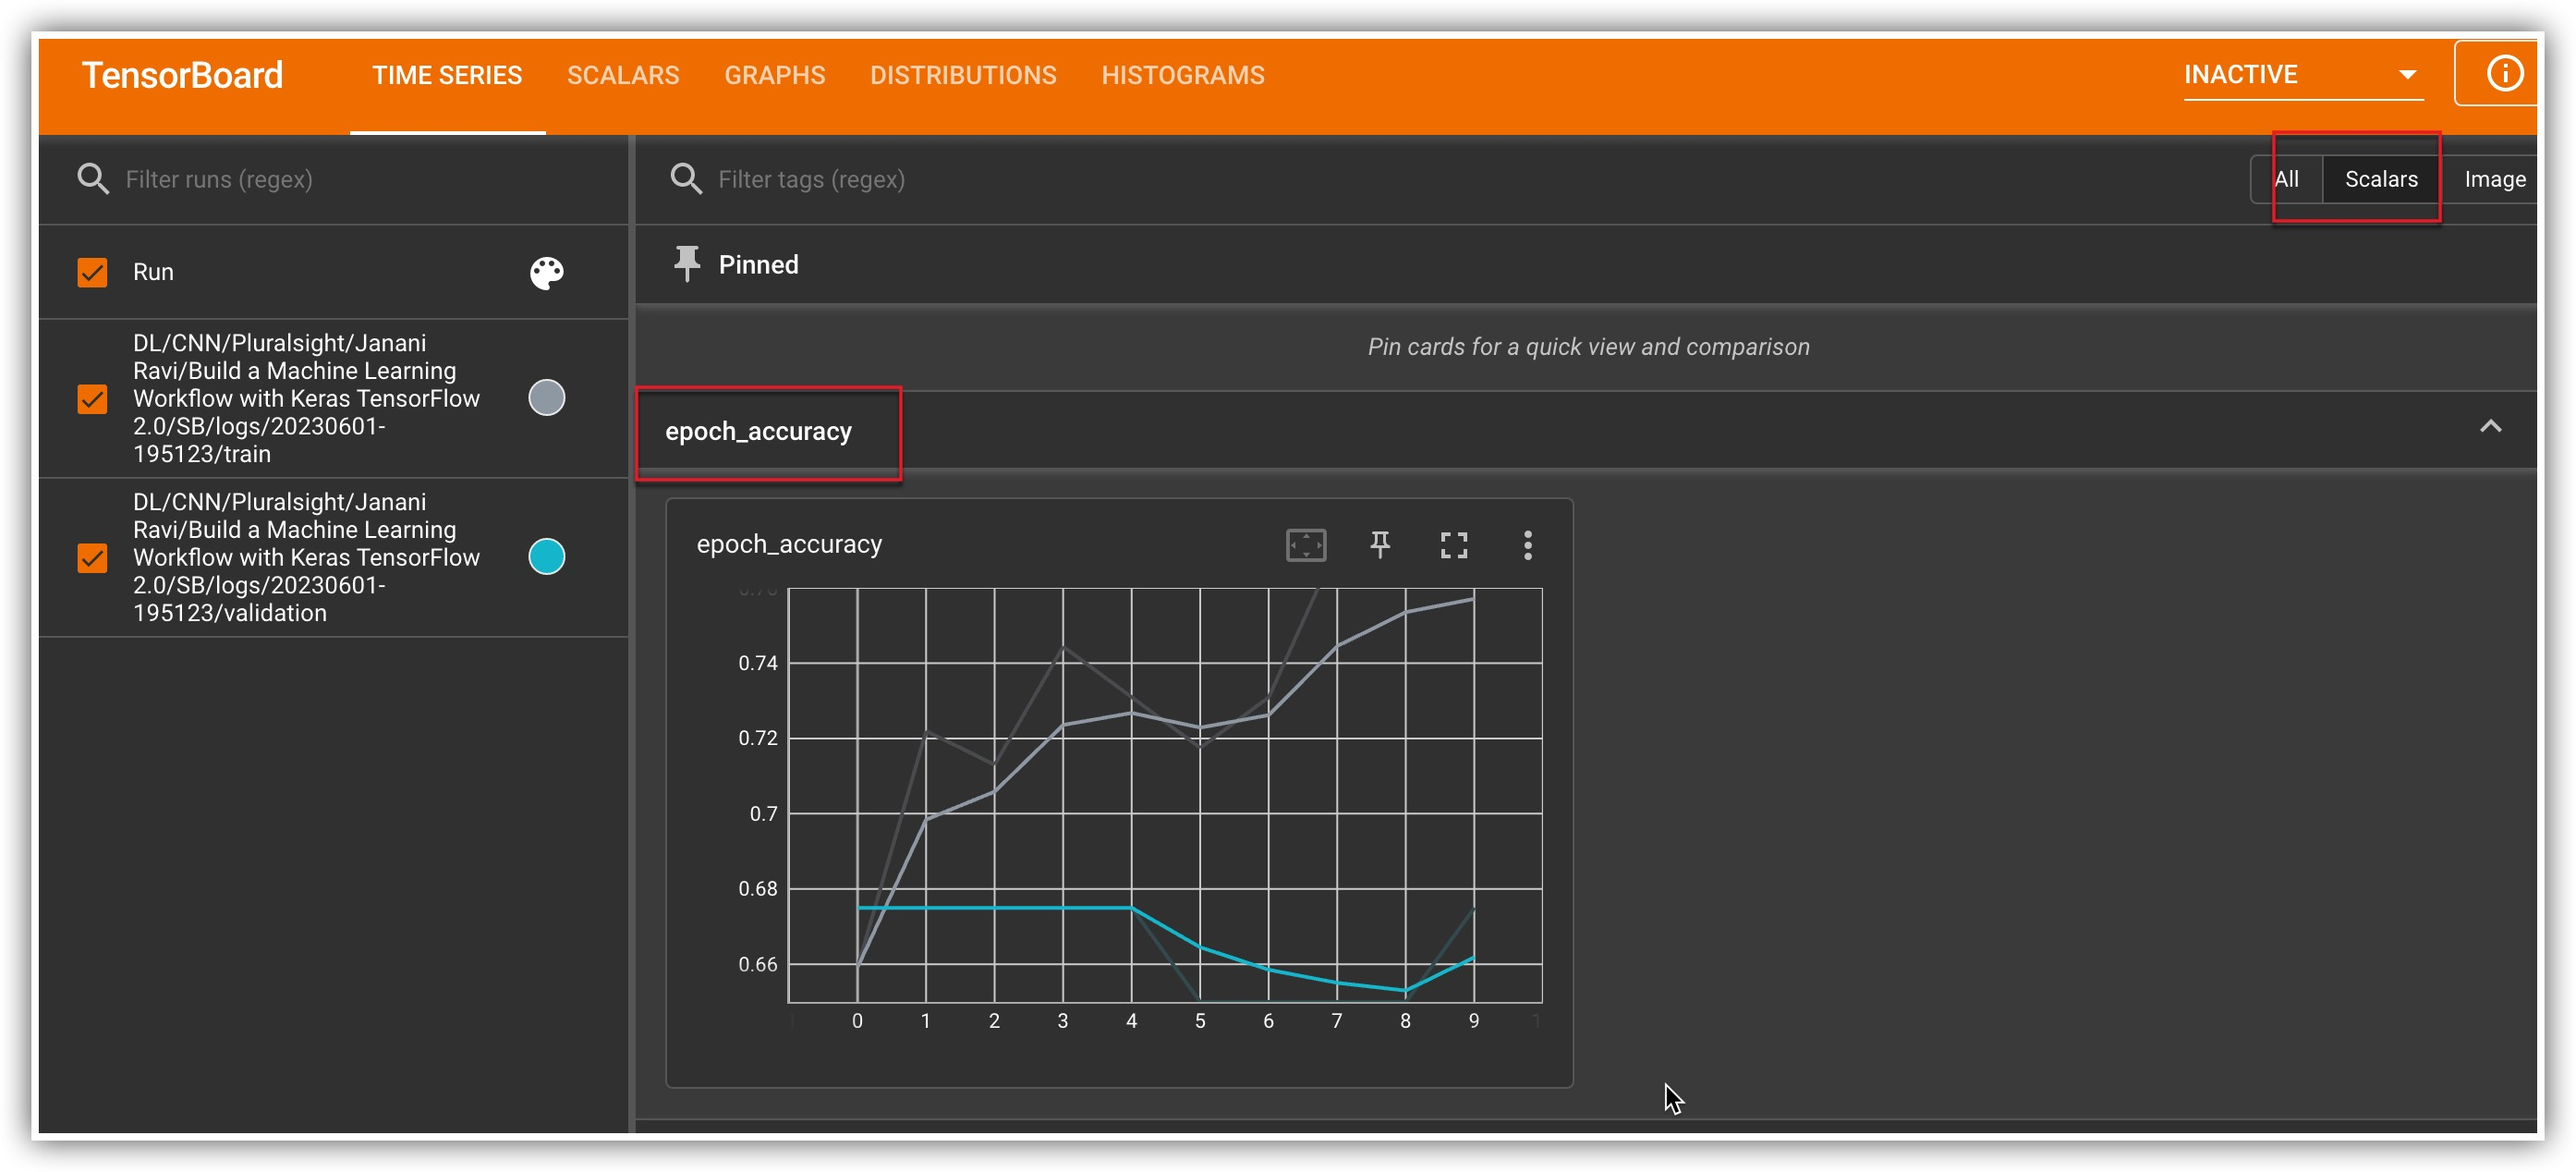

In [155]:
'''
he first tab here shows the scalars that you can monitor during the training process. 
This gives you the epoch accuracy. How accuracy changes during the 10 epochs of training 
is plotted both for training data in orange, as well as validation data in blue. I
'''
Image('/Users/subhasish/Development/GIT/Interstellar/SB-AI-DEV/DL/CNN/Pluralsight/Janani Ravi/Build a Machine Learning Workflow with Keras TensorFlow 2.0/SB/Images/2023-06-01_20-31-43.jpg')

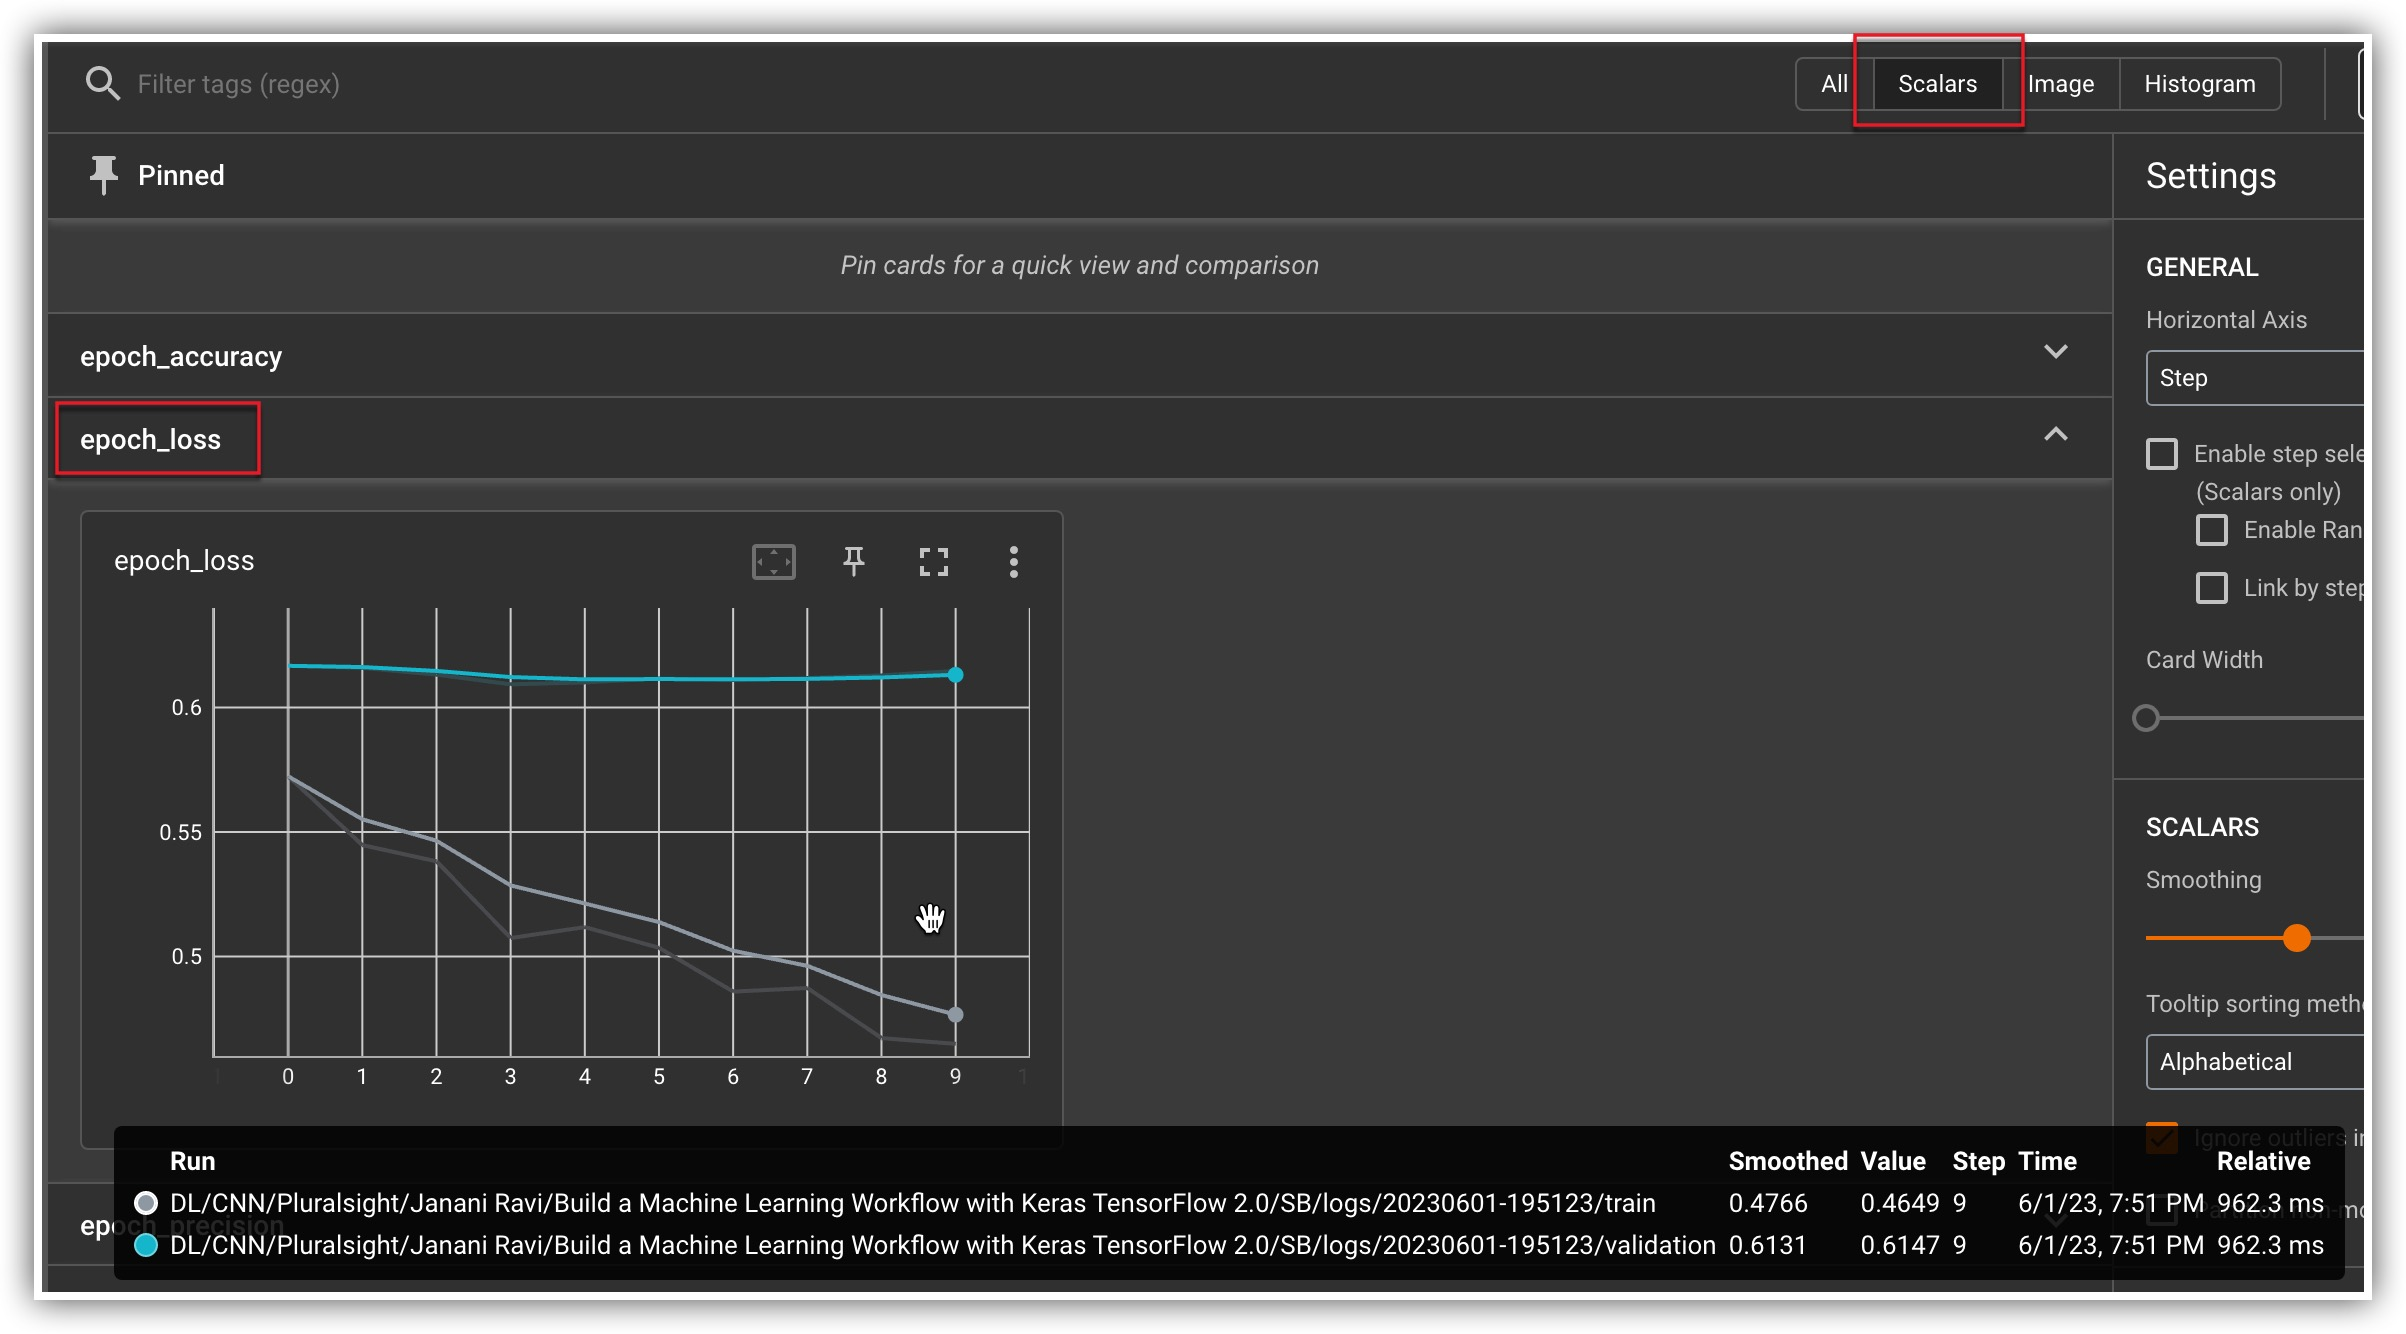

In [156]:
'''
Here is the epoch loss, loss on the Y‑axis, epochs on the X‑axis. 
These graphs will also plot other metrics that we are tracking for our model.
'''
Image('/Users/subhasish/Development/GIT/Interstellar/SB-AI-DEV/DL/CNN/Pluralsight/Janani Ravi/Build a Machine Learning Workflow with Keras TensorFlow 2.0/SB/Images/2023-06-01_20-35-57.jpg')

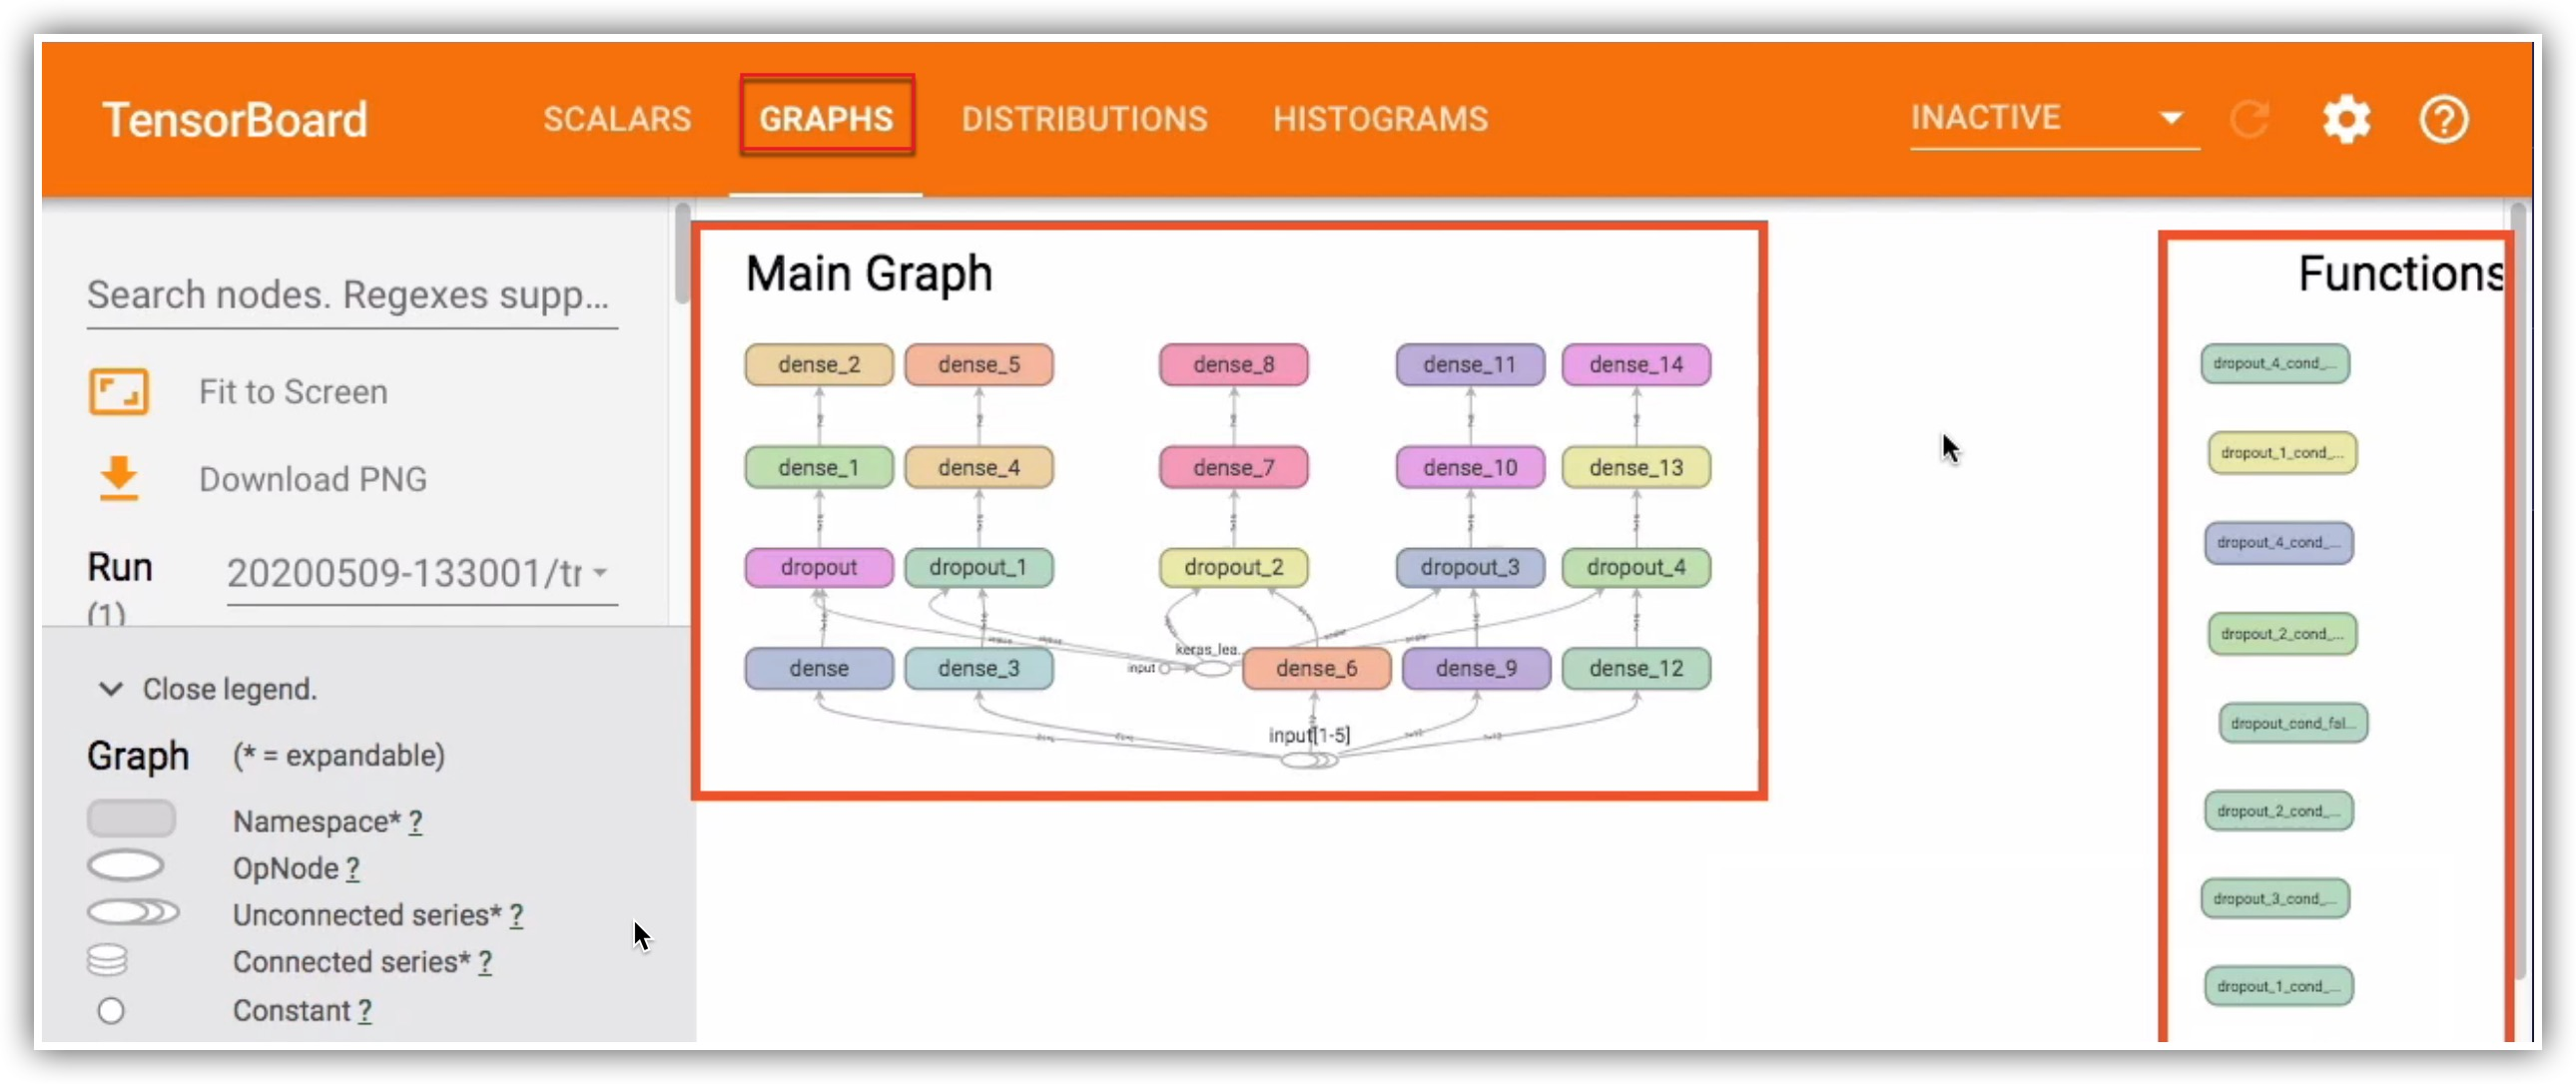

In [157]:
'''
f you head over to the Graphs tab, you'll be able to see a graphical visualization of your model. 
You can see that this graph represents the individual layers in our Keras model. 

The input is fed in through a dense layer, then a dropout layer, and two more dense layers. 
'''
Image('/Users/subhasish/Development/GIT/Interstellar/SB-AI-DEV/DL/CNN/Pluralsight/Janani Ravi/Build a Machine Learning Workflow with Keras TensorFlow 2.0/SB/Images/2023-06-01_20-38-30.jpg')

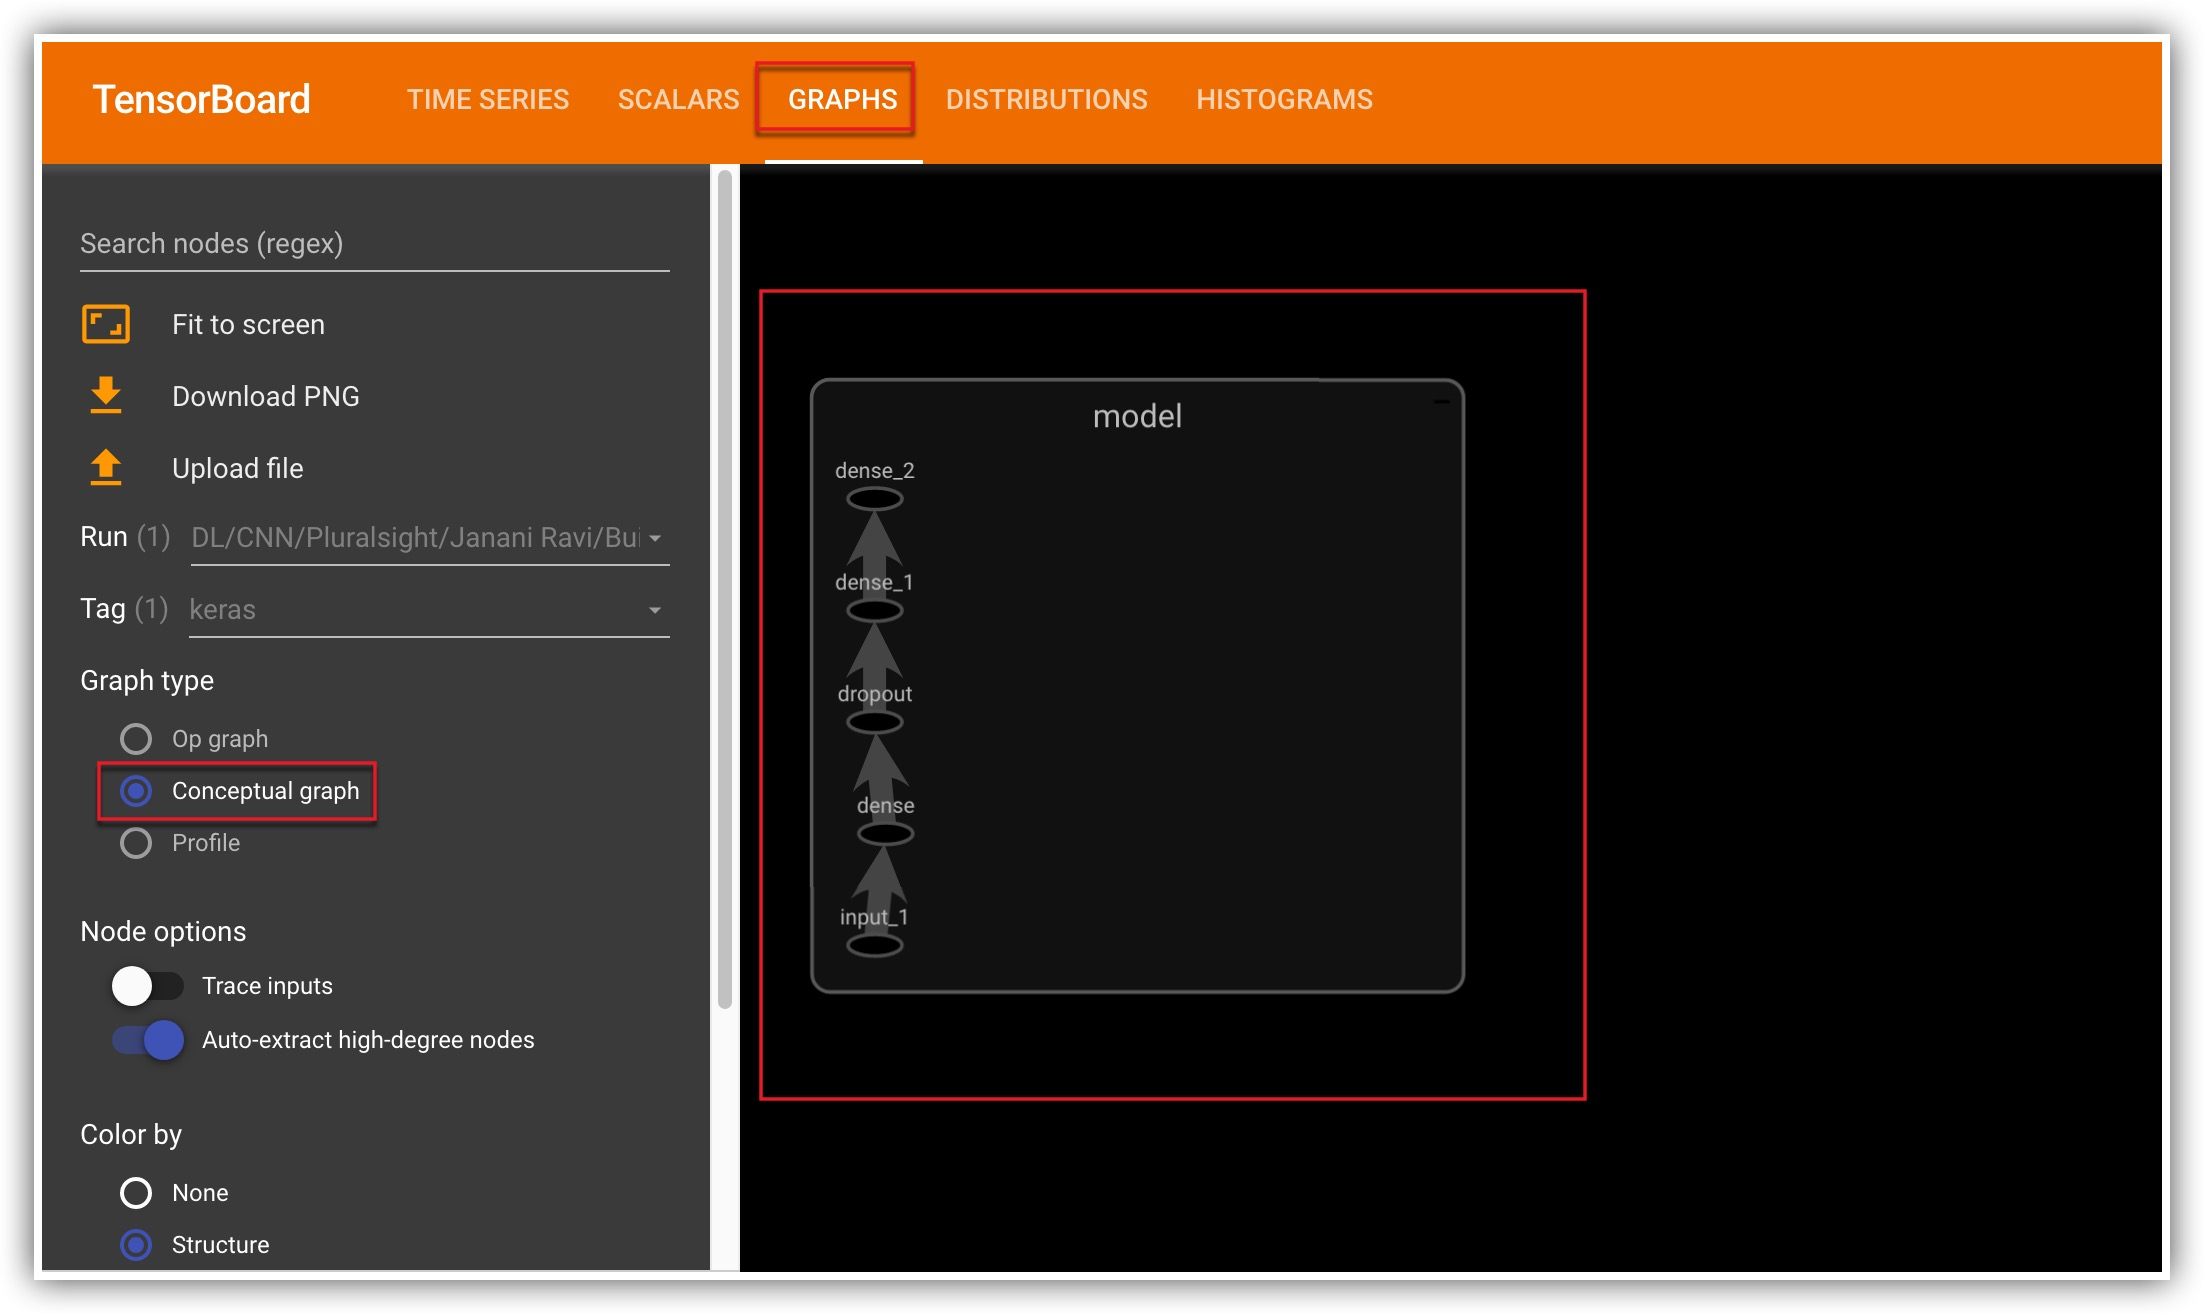

In [158]:
'''
You can use this dropdown to view a Keras view of the graph as well. 
This will show you our model in terms of layers. Under the hood, Keras assigns each layer a specific name, 
and that name is used to refer to a particular layer.
'''
Image('/Users/subhasish/Development/GIT/Interstellar/SB-AI-DEV/DL/CNN/Pluralsight/Janani Ravi/Build a Machine Learning Workflow with Keras TensorFlow 2.0/SB/Images/2023-06-01_20-41-54.jpg')

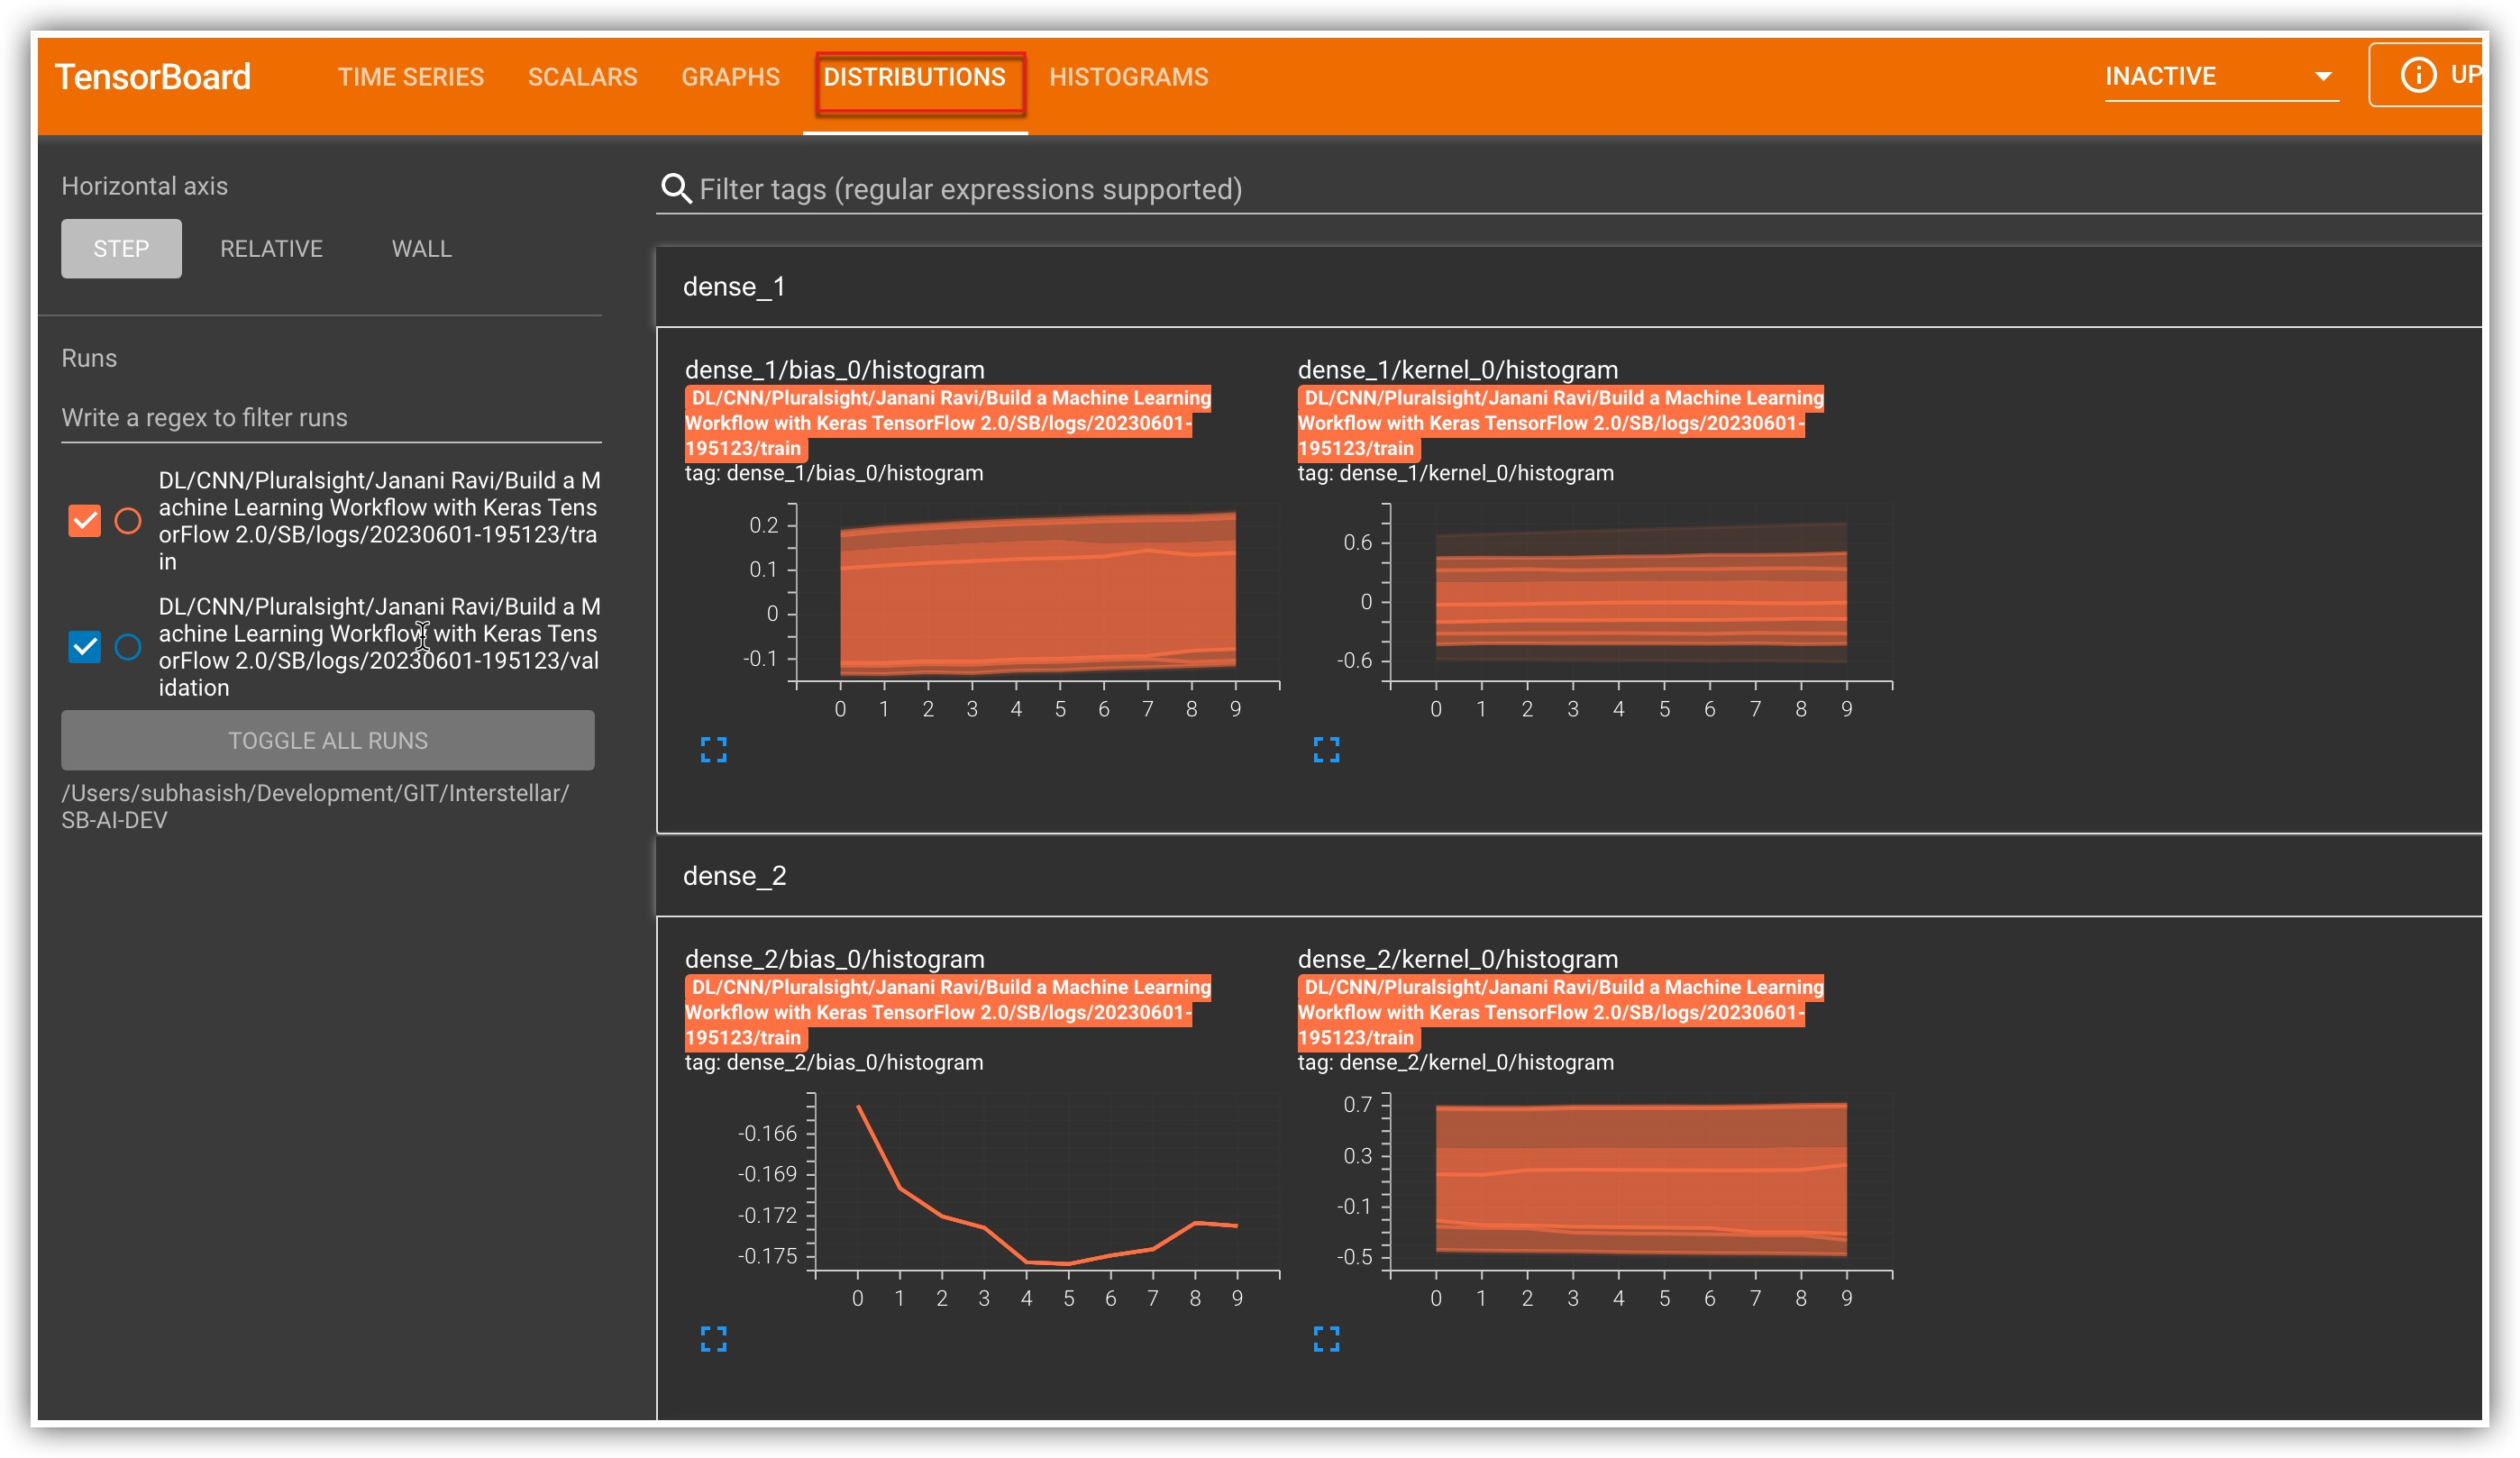

In [159]:
'''
The Distributions tab here allows you to visualize how your model 
parameters change during the training process. 

Here is a distribution of our dense_12 layer. On the left‑hand side, 
we have the distribution over the epochs of training for the bias of this layer. 

And on the right‑hand side, we have the distribution for the weights of this layer. 
If you find that your model parameters are not converging, that'll show up here in this distribution. 
'''
Image('/Users/subhasish/Development/GIT/Interstellar/SB-AI-DEV/DL/CNN/Pluralsight/Janani Ravi/Build a Machine Learning Workflow with Keras TensorFlow 2.0/SB/Images/2023-06-01_20-44-17.jpg')

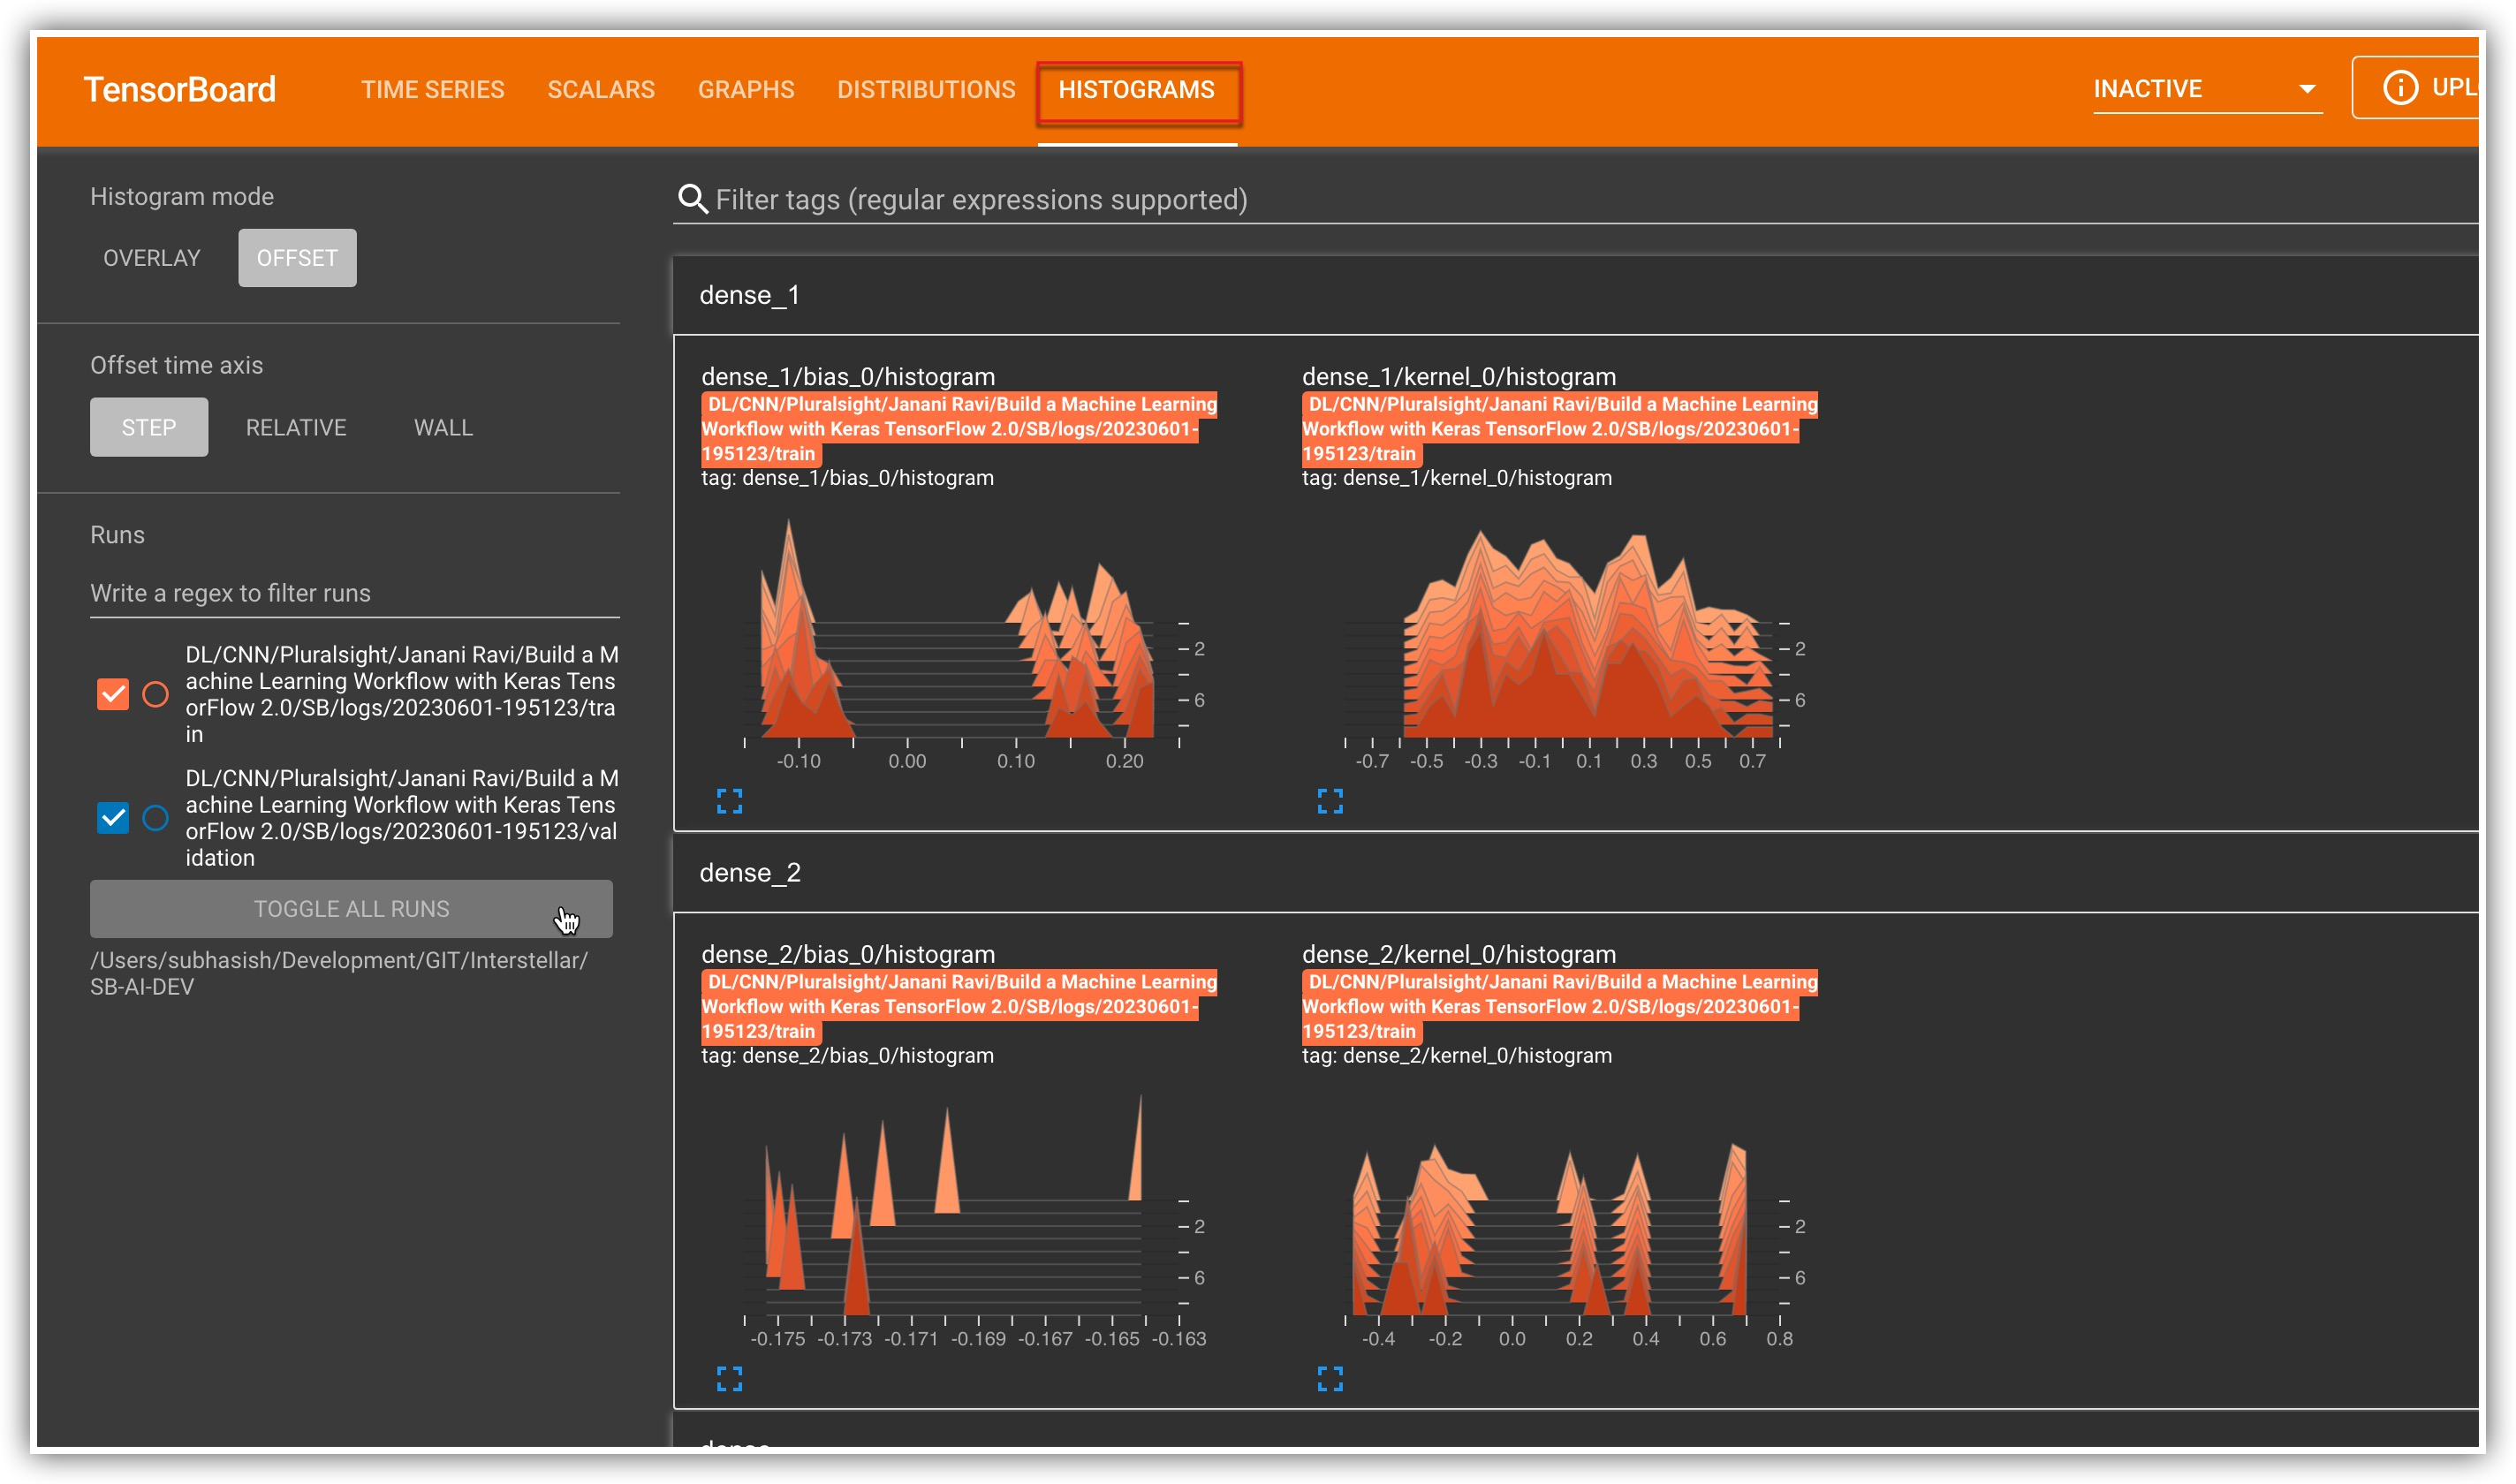

In [160]:
'''
The Histogram tab gives us a histogram representation of the model 
parameters weights, as well as biases for each epoch. 

This is a 3‑dimensional representation as you can see where model parameters weights, 
as well as biases are plotted for each epoch. 
'''
Image('/Users/subhasish/Development/GIT/Interstellar/SB-AI-DEV/DL/CNN/Pluralsight/Janani Ravi/Build a Machine Learning Workflow with Keras TensorFlow 2.0/SB/Images/2023-06-01_20-47-56.jpg')